# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Setup

You can get the zip files from Zindi or add to your Google drive using the following links:

Test data: https://drive.google.com/file/d/1yTEgzn8JJn0mZmJ7NDUbwAB1WSzwRScB/view?usp=sharing

Training data: 
https://drive.google.com/file/d/1-0UNiBpvfdRq8rgUC3Kb22YPWP_YnoKj/view?usp=sharing

You'll also need the smaller files from Zindi (Train.csv, SampleSubmission.csv and bandnames.txt) which you can just upload using the files tab.

In [41]:
cd /Users/krishnapatel/MyDesk/Internship2021

/Users/krishnapatel/MyDesk/Internship2021


In [42]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp 'image_arrays_train.zip' .
!cp 'image_arrays_test.zip' .

cp: ./image_arrays_train.zip and image_arrays_train.zip are identical (not copied).
cp: ./image_arrays_test.zip and image_arrays_test.zip are identical (not copied).


In [43]:
# Extract
#!unzip -q image_arrays_train.zip
#!unzip -q image_arrays_test.zip

In [44]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

Corr_Skew.csv                fields_w_additional_info.csv
SampleSubmission.csv         isnull.csv
Sub.csv                      ndvi.csv
Train.csv                    new_trainsample.csv
X2.csv                       sample.csv
X3.csv                       sample1.csv
cor_skew1.csv                skewness.csv
correlation.csv              test_field_ids_with_year.csv
correlation1.csv


In [45]:
# Check for bandnames.txt
!ls *.txt

bandnames.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [47]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Loading image_arrays_train/DPMMLDM.npy as an array
Array shape: (360, 41, 41)


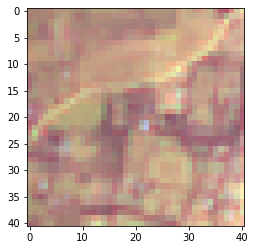

In [48]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

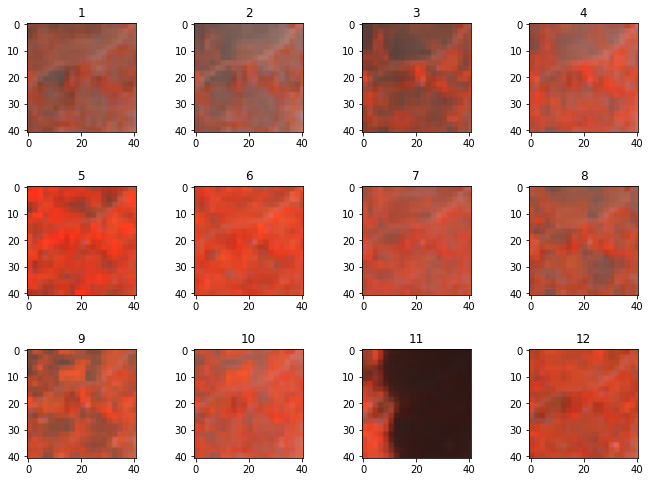

In [49]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

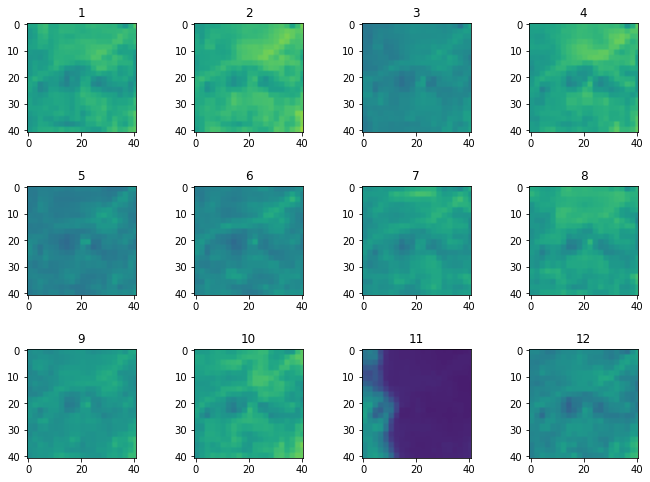

In [50]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [51]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
#print(band_names)
#print(len(band_names))

# Fetching Column names for extracking the area of the field from the data

In [52]:
#print(new_band_names)
n = len(band_names)
new_band_names = []
for i in range(n):
    x = band_names[i].split('_',1)[1:]
    y ='_'.join(x)
    new_band_names.append(y)

new_band_names1 = new_band_names[:360]
#print(new_band_names[:360])

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [53]:
def process_im(fid, folder='image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  #bands_of_interest = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
  bands_of_interest = new_band_names1
  values = {}
  for month in range(12):
    if month == 3:
        pass
    elif month == 4:
        pass
    elif month == 5:
        pass
    else :
        bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
        idxs = np.where(np.isin(band_names, bns)) # Index of these bands
        vs = arr[idxs, 21, 21] # Sample the im at the center point
        for bn, v in zip(bns, vs[0]):
          values[bn] = v
  return values

# Example
# process_im('35AFSDD')

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [54]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,0_S2_B1,0_S2_B2,0_S2_B3,0_S2_B4,0_S2_B5,0_S2_B6,0_S2_B7,0_S2_B8,0_S2_B8A,0_S2_B9,...,11_CLIM_soil,11_CLIM_srad,11_CLIM_swe,11_CLIM_tmmn,11_CLIM_tmmx,11_CLIM_vap,11_CLIM_vpd,11_CLIM_vs,Field_ID,Yield
0,1009,910,956,1175,1446,1895,2142,2078,2449,1123,...,215,1880,0,100,267,1680,69,210,MH2O0YH,3.686
1,1023,869,867,880,1192,1958,2273,2239,2613,929,...,215,1883,0,99,273,1682,75,190,O9TURWL,5.657
2,1117,994,1019,1289,1427,1739,2017,2114,2367,983,...,289,1875,0,100,274,1690,76,200,35AFSDD,3.082
3,976,746,668,600,891,2009,2292,2171,2608,1300,...,189,1898,0,98,263,1688,64,210,PM05EG9,2.707
4,1300,1060,1073,1056,1310,2282,2678,2626,2966,710,...,1214,1930,0,143,291,1972,87,270,V7PZBCG,2.679


In [55]:
train_sampled.to_csv('sample.csv', index = True)

Deleting the unwanted rows for checking the skewness

In [56]:
train_sampled1 = train_sampled.dropna(axis=1)

uniquevalue = []

print(uniquevalue)
type(uniquevalue)

for i in train_sampled1.columns:
    if train_sampled1[i].nunique() == 1:
        del train_sampled1[i]
train_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)
#del train_sampled1['Field_ID']
#train_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','3_S2_QA60','3_CLIM_def','3_CLIM_pdsi','4_S2_QA60','5_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','4_CLIM_pdsi', '5_CLIM_pdsi', '6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)
#print(train_sampled1)
train_sampled1.to_csv('sample1.csv', index = True)
train_sampled1.shape

[]


(2977, 230)

Finding correlation of the data with the target class

In [57]:
train_sampled1.corr()

,0_S2_B1,0_S2_B2,0_S2_B3,0_S2_B4,0_S2_B5,0_S2_B6,0_S2_B7,0_S2_B8,0_S2_B8A,0_S2_B9,...,11_CLIM_pr,11_CLIM_ro,11_CLIM_soil,11_CLIM_srad,11_CLIM_tmmn,11_CLIM_tmmx,11_CLIM_vap,11_CLIM_vpd,11_CLIM_vs,Yield
0_S2_B1,1.000000,0.828606,0.753072,0.542654,0.578806,0.342423,0.253011,0.239892,0.241369,0.059942,...,0.009480,0.020768,0.059281,-0.017373,0.271314,0.176022,0.265167,-0.011206,0.045345,-0.071658
0_S2_B2,0.828606,1.000000,0.952894,0.782616,0.729438,0.309852,0.195209,0.225341,0.187746,0.206360,...,-0.019731,-0.010653,0.004862,-0.006700,0.136371,0.075029,0.142089,-0.017483,-0.037457,-0.007192
0_S2_B3,0.753072,0.952894,1.000000,0.838585,0.819133,0.410241,0.278901,0.336686,0.272110,0.286622,...,-0.086982,-0.060492,-0.072185,0.058743,0.132513,0.097046,0.070527,0.046632,0.006298,-0.009597
0_S2_B4,0.542654,0.782616,0.838585,1.000000,0.911650,0.050676,-0.107666,-0.018507,-0.104824,0.501238,...,-0.166248,-0.153210,-0.194330,0.113361,-0.001582,-0.061212,-0.084202,0.040455,-0.086341,0.099901
0_S2_B5,0.578806,0.729438,0.819133,0.911650,1.000000,0.274344,0.103124,0.187175,0.110002,0.564795,...,-0.243188,-0.200891,-0.259197,0.184411,0.061745,0.014958,-0.111980,0.118433,0.018762,0.068758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11_CLIM_tmmx,0.176022,0.075029,0.097046,-0.061212,0.014958,0.304791,0.308139,0.243920,0.301405,-0.214226,...,-0.412878,-0.291127,-0.421435,0.610465,0.813504,1.000000,0.121181,0.738512,0.712739,-0.325542
11_CLIM_vap,0.265167,0.142089,0.070527,-0.084202,-0.111980,0.112038,0.128551,0.045119,0.098411,-0.357911,...,0.714398,0.523742,0.676061,-0.570645,0.386287,0.121181,1.000000,-0.524125,-0.031380,-0.174377
11_CLIM_vpd,-0.011206,-0.017483,0.046632,0.040455,0.118433,0.152677,0.137126,0.145030,0.154924,0.066040,...,-0.829711,-0.641816,-0.846186,0.942187,0.534521,0.738512,-0.524125,1.000000,0.621819,-0.173568
11_CLIM_vs,0.045345,-0.037457,0.006298,-0.086341,0.018762,0.317703,0.313878,0.270211,0.289880,0.030121,...,-0.496848,-0.253978,-0.444939,0.564508,0.674545,0.712739,-0.031380,0.621819,1.000000,-0.329671


In [58]:
"""import seaborn as sns
corrMatrix = train_sampled1.corr()
plt.figure(figsize=(128, 128))
sns.heatmap(corrMatrix,annot=True)"""

'import seaborn as sns\ncorrMatrix = train_sampled1.corr()\nplt.figure(figsize=(128, 128))\nsns.heatmap(corrMatrix,annot=True)'

In [59]:
corrMatrix = train_sampled1.corr()
corrMatrix.to_csv('correlation1.csv', index = True) #saving the correlation values for checking correlation

# Checking the Skewness of Data

In [60]:
train_sampled1.skew(axis = 1, skipna = True)

0       0.550986
1       0.859946
2       1.077464
3       2.480985
4       0.714773
          ...   
2972    0.714145
2973    0.731889
2974    2.965149
2975    0.740862
2976    0.752084
Length: 2977, dtype: float64

Checking skewness Columnwise

In [61]:
skewness = train_sampled1.skew(axis = 0, skipna = True)
print(skewness)
#skewness.to_csv('skewness.csv', index = True)

0_S2_B1         8.630878
0_S2_B2         6.021276
0_S2_B3         3.785049
0_S2_B4         1.013252
0_S2_B5         1.108358
                  ...   
11_CLIM_tmmx   -1.089171
11_CLIM_vap     0.303696
11_CLIM_vpd    -1.380436
11_CLIM_vs     -0.787914
Yield           1.004717
Length: 229, dtype: float64


In [62]:
 corr_skew = pd.read_csv('cor_skew1.csv')

In [63]:
labels = []
for n in range(len(corr_skew)):
    if (corr_skew['Skew'][n] > 0.49) and (corr_skew['Correlation'][n] > 0.099) :
        labels.append(corr_skew['Bands'][n])
    if (corr_skew['Skew'][n] > 0.49) and (corr_skew['Correlation'][n] < -0.099) :
        labels.append(corr_skew['Bands'][n])
print(labels)

['0_S2_B4', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '1_CLIM_srad', '1_CLIM_vpd', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B11', '6_S2_B7', '6_S2_B8', '6_S2_B8A', '6_S2_B9', '6_CLIM_pr', '6_CLIM_ro', '7_S2_B9', '7_CLIM_pr', '7_CLIM_ro', '7_CLIM_soil', '8_S2_B11', '8_S2_B12', '8_CLIM_def', '8_CLIM_soil', '9_S2_B1', '9_S2_B2', '9_S2_B3', '9_S2_B4', '10_S2_B10', '10_CLIM_def', '10_CLIM_pr', '10_CLIM_ro', '11_S2_B9']


In [64]:
print(len(labels))

39


In [65]:
from scipy.stats import skew
import seaborn as sns
from matplotlib import pyplot as plt
x, y  = train_sampled[train_sampled1.columns[:-2]], train_sampled1['Yield']

Changing the skewness using sqaureroot transformation

In [66]:
import copy
X1 = copy.deepcopy(x)  
for i in labels:
    X1[i] = np.sqrt(X1[i])  
skewness = X1.skew()
print(skewness)

0_S2_B1         8.630878
0_S2_B2         6.021276
0_S2_B3         3.785049
0_S2_B4         0.362564
0_S2_B5         1.108358
                  ...   
11_CLIM_tmmn   -0.249402
11_CLIM_tmmx   -1.089171
11_CLIM_vap     0.303696
11_CLIM_vpd    -1.380436
11_CLIM_vs     -0.787914
Length: 228, dtype: float64


From the above boxplot graph we can observe that after applying squareroot transformation we can see that there is outliers.

In [67]:
import copy
X2 = copy.deepcopy(x)  
for i in labels:
    X2[i] = (X2[i])**(1./3.)
print("-----------Change in skewness-----------")
for i in labels:
    print(i)
    print(skew(X2[i]))

-----------Change in skewness-----------
0_S2_B4
0.19078894272747118
0_CLIM_pr
0.32816659003431176
0_CLIM_ro
-1.030859365204628
0_CLIM_soil
0.2280723293086467
1_CLIM_srad
0.7252426584947814
1_CLIM_vpd
1.6432685087698617
2_S2_B1
3.08769527995748
2_S2_B2
3.049294082977929
2_S2_B3
2.958577357292642
2_S2_B4
2.5468102811635265
2_S2_B5
2.745252813304144
2_S2_B6
2.1554971548676733
2_S2_B7
1.8152832049799803
2_S2_B8
1.6765218262255188
2_S2_B8A
1.5645094913797541
2_S2_B11
0.15691302390527853
6_S2_B7
0.9417814960899772
6_S2_B8
0.7627082860727558
6_S2_B8A
0.47717703849909343
6_S2_B9
2.8204428323305324
6_CLIM_pr
0.28443497405205176
6_CLIM_ro
0.02125265577166486
7_S2_B9
2.7480277847049086
7_CLIM_pr
0.13223741727537278
7_CLIM_ro
3.485384867434569
7_CLIM_soil
1.7408497338574191
8_S2_B11
0.1366867620579907
8_S2_B12
0.6106420258545461
8_CLIM_def
-0.9613429803364587
8_CLIM_soil
2.137530293313046
9_S2_B1
3.523196971858695
9_S2_B2
3.415516689366489
9_S2_B3
3.3118113074674196
9_S2_B4
2.674979415811619
10_S

In [68]:
X4 = x.copy()
for i in labels:
    X4[i] = X4[i]+1
for i in labels:
    X4[i] = np.log10(X4[i])

In [69]:
import copy
X3 = copy.deepcopy(x)  
for i in labels:
    X3[i] = (X3[i])**(1./10.)
print("-----------Change in skewness-----------")
for i in labels:
    print(i)
    print(skew(X3[i]))

-----------Change in skewness-----------
0_S2_B4
-0.030948561365571274
0_CLIM_pr
-0.24904154244026794
0_CLIM_ro
-2.264721309286936
0_CLIM_soil
0.0651849662208444
1_CLIM_srad
0.6927619150628608
1_CLIM_vpd
1.5679836002778729
2_S2_B1
2.8395152430657506
2_S2_B2
2.75106181154525
2_S2_B3
2.6043429107049882
2_S2_B4
2.02608206415246
2_S2_B5
2.272171963503445
2_S2_B6
1.58801720999332
2_S2_B7
1.2478253124794756
2_S2_B8
1.0898756051663845
2_S2_B8A
0.9853594568971825
2_S2_B11
-0.45635981492270006
6_S2_B7
0.21998135455609422
6_S2_B8
0.029154250144348144
6_S2_B8A
-0.2614766307973588
6_S2_B9
1.8966499143109545
6_CLIM_pr
-0.09032877786902825
6_CLIM_ro
-3.46218893837516
7_S2_B9
1.8324782197266245
7_CLIM_pr
-1.0574528501811788
7_CLIM_ro
-2.808082363522988
7_CLIM_soil
1.1745789261531454
8_S2_B11
-0.7315358142446642
8_S2_B12
-0.014702875313426317
8_CLIM_def
-2.403496497982931
8_CLIM_soil
1.54962073607822
9_S2_B1
3.252289990793892
9_S2_B2
3.0951838031873216
9_S2_B3
2.9242551139206445
9_S2_B4
2.122241228855

# Fitting a model

Now that we have a way to get features from the inputs, we can fit a model and see how it does:

In [70]:
from sklearn import preprocessing
import pandas as pd
from sklearn import preprocessing

x = X3.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_nor = pd.DataFrame(x_scaled)

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_nor, y, test_size=0.15)

In [72]:
import tensorflow as tf
from tensorflow import keras
#from keras import backend as keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.layers import Dropout, Flatten,Activation

In [73]:
model = keras.Sequential([
    layers.Dense(96, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse', optimizer= optimizer, metrics = ['mae', 'mse'])

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 96)                21984     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 32,417
Trainable params: 32,417
Non-trainable params: 0
_________________________________________________________________


In [75]:
#from keras.callbacks import EarlyStopping

EPOCHS = 4000

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Train on 2024 samples, validate on 506 samples
Epoch 1/4000
2024/2024 [==============================] - 8s 4ms/sample - loss: 3.1595 - mae: 1.3685 - mse: 3.1595 - val_loss: 2.7383 - val_mae: 1.3169 - val_mse: 2.7383
Epoch 2/4000
2024/2024 [==============================] - 1s 723us/sample - loss: 2.7285 - mae: 1.2598 - mse: 2.7285 - val_loss: 2.6317 - val_mae: 1.2309 - val_mse: 2.6317
Epoch 3/4000
2024/2024 [==============================] - 1s 655us/sample - loss: 2.5978 - mae: 1.2257 - mse: 2.5978 - val_loss: 2.7877 - val_mae: 1.2507 - val_mse: 2.7877
Epoch 4/4000
2024/2024 [==============================] - 1s 685us/sample - loss: 2.6191 - mae: 1.2348 - mse: 2.6191 - val_loss: 2.5607 - val_mae: 1.2214 - val_mse: 2.5607
Epoch 5/4000
2024/2024 [==============================] - 1s 666us/sample - loss: 2.6032 - mae: 1.2317 - mse: 2.6032 - val_loss: 2.6031 - val_mae: 1.2226 - val_mse: 2.6031
Epoch 6/4000
2024/2024 [==============================] - 2s 789us/sample - loss: 2.5573 - mae:

2024/2024 [==============================] - 1s 648us/sample - loss: 1.9703 - mae: 1.0659 - mse: 1.9703 - val_loss: 2.5436 - val_mae: 1.2336 - val_mse: 2.5436
Epoch 95/4000
2024/2024 [==============================] - 1s 583us/sample - loss: 1.9579 - mae: 1.0547 - mse: 1.9579 - val_loss: 2.6859 - val_mae: 1.2390 - val_mse: 2.6859
Epoch 96/4000
2024/2024 [==============================] - 1s 529us/sample - loss: 1.9558 - mae: 1.0508 - mse: 1.9558 - val_loss: 2.6272 - val_mae: 1.2626 - val_mse: 2.6272
Epoch 97/4000
2024/2024 [==============================] - 1s 521us/sample - loss: 1.9515 - mae: 1.0478 - mse: 1.9515 - val_loss: 2.5609 - val_mae: 1.2457 - val_mse: 2.5609
Epoch 98/4000
2024/2024 [==============================] - 1s 586us/sample - loss: 1.9313 - mae: 1.0518 - mse: 1.9313 - val_loss: 2.5866 - val_mae: 1.2374 - val_mse: 2.5866
Epoch 99/4000
2024/2024 [==============================] - 1s 541us/sample - loss: 1.9167 - mae: 1.0476 - mse: 1.9167 - val_loss: 2.6499 - val_mae: 1

2024/2024 [==============================] - 1s 599us/sample - loss: 1.5488 - mae: 0.9252 - mse: 1.5488 - val_loss: 2.8567 - val_mae: 1.3037 - val_mse: 2.8567
Epoch 189/4000
2024/2024 [==============================] - 1s 547us/sample - loss: 1.5892 - mae: 0.9348 - mse: 1.5892 - val_loss: 2.7395 - val_mae: 1.2571 - val_mse: 2.7395
Epoch 190/4000
2024/2024 [==============================] - 1s 547us/sample - loss: 1.5650 - mae: 0.9310 - mse: 1.5650 - val_loss: 2.6324 - val_mae: 1.2223 - val_mse: 2.6324
Epoch 191/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 1.5758 - mae: 0.9342 - mse: 1.5758 - val_loss: 2.9601 - val_mae: 1.3396 - val_mse: 2.9601
Epoch 192/4000
2024/2024 [==============================] - 1s 679us/sample - loss: 1.5489 - mae: 0.9270 - mse: 1.5489 - val_loss: 2.7650 - val_mae: 1.2708 - val_mse: 2.7650
Epoch 193/4000
2024/2024 [==============================] - 1s 690us/sample - loss: 1.5770 - mae: 0.9281 - mse: 1.5770 - val_loss: 2.7284 - val_mae

2024/2024 [==============================] - 1s 643us/sample - loss: 1.2380 - mae: 0.8142 - mse: 1.2380 - val_loss: 2.9330 - val_mae: 1.3058 - val_mse: 2.9330
Epoch 283/4000
2024/2024 [==============================] - 1s 611us/sample - loss: 1.2377 - mae: 0.8248 - mse: 1.2377 - val_loss: 3.1600 - val_mae: 1.3267 - val_mse: 3.1600
Epoch 284/4000
2024/2024 [==============================] - 1s 534us/sample - loss: 1.2269 - mae: 0.8134 - mse: 1.2269 - val_loss: 4.3205 - val_mae: 1.5818 - val_mse: 4.3205
Epoch 285/4000
2024/2024 [==============================] - 1s 588us/sample - loss: 1.1976 - mae: 0.8031 - mse: 1.1976 - val_loss: 2.9819 - val_mae: 1.3218 - val_mse: 2.9819
Epoch 286/4000
2024/2024 [==============================] - 1s 500us/sample - loss: 1.2306 - mae: 0.8151 - mse: 1.2306 - val_loss: 3.9381 - val_mae: 1.5503 - val_mse: 3.9381
Epoch 287/4000
2024/2024 [==============================] - 2s 803us/sample - loss: 1.1985 - mae: 0.8084 - mse: 1.1985 - val_loss: 3.0236 - val_m

2024/2024 [==============================] - 1s 574us/sample - loss: 0.9957 - mae: 0.7250 - mse: 0.9957 - val_loss: 3.2783 - val_mae: 1.3685 - val_mse: 3.2783
Epoch 377/4000
2024/2024 [==============================] - 1s 531us/sample - loss: 0.9270 - mae: 0.7019 - mse: 0.9270 - val_loss: 3.5811 - val_mae: 1.4441 - val_mse: 3.5811
Epoch 378/4000
2024/2024 [==============================] - 1s 545us/sample - loss: 0.9346 - mae: 0.7004 - mse: 0.9346 - val_loss: 3.2814 - val_mae: 1.3991 - val_mse: 3.2814
Epoch 379/4000
2024/2024 [==============================] - 1s 573us/sample - loss: 0.9358 - mae: 0.7059 - mse: 0.9358 - val_loss: 3.4417 - val_mae: 1.4206 - val_mse: 3.4417
Epoch 380/4000
2024/2024 [==============================] - 1s 561us/sample - loss: 0.9565 - mae: 0.7117 - mse: 0.9565 - val_loss: 3.3229 - val_mae: 1.3908 - val_mse: 3.3229
Epoch 381/4000
2024/2024 [==============================] - 1s 642us/sample - loss: 0.9081 - mae: 0.6963 - mse: 0.9081 - val_loss: 3.4098 - val_m

2024/2024 [==============================] - 1s 572us/sample - loss: 0.7157 - mae: 0.6130 - mse: 0.7157 - val_loss: 3.6824 - val_mae: 1.4762 - val_mse: 3.6824
Epoch 471/4000
2024/2024 [==============================] - 1s 627us/sample - loss: 0.7244 - mae: 0.6199 - mse: 0.7244 - val_loss: 3.7148 - val_mae: 1.4698 - val_mse: 3.7148
Epoch 472/4000
2024/2024 [==============================] - 1s 608us/sample - loss: 0.6854 - mae: 0.6079 - mse: 0.6854 - val_loss: 3.3914 - val_mae: 1.3994 - val_mse: 3.3914
Epoch 473/4000
2024/2024 [==============================] - 1s 595us/sample - loss: 0.7631 - mae: 0.6268 - mse: 0.7631 - val_loss: 3.6284 - val_mae: 1.4477 - val_mse: 3.6284
Epoch 474/4000
2024/2024 [==============================] - 1s 636us/sample - loss: 0.7111 - mae: 0.6034 - mse: 0.7111 - val_loss: 3.6351 - val_mae: 1.4546 - val_mse: 3.6351
Epoch 475/4000
2024/2024 [==============================] - 1s 658us/sample - loss: 0.6997 - mae: 0.6096 - mse: 0.6997 - val_loss: 3.7214 - val_m

2024/2024 [==============================] - 1s 606us/sample - loss: 0.5467 - mae: 0.5431 - mse: 0.5467 - val_loss: 3.8124 - val_mae: 1.5081 - val_mse: 3.8124
Epoch 565/4000
2024/2024 [==============================] - 1s 556us/sample - loss: 0.5582 - mae: 0.5367 - mse: 0.5582 - val_loss: 3.6052 - val_mae: 1.4420 - val_mse: 3.6052
Epoch 566/4000
2024/2024 [==============================] - 2s 784us/sample - loss: 0.5480 - mae: 0.5365 - mse: 0.5480 - val_loss: 4.1485 - val_mae: 1.5771 - val_mse: 4.1485
Epoch 567/4000
2024/2024 [==============================] - 1s 691us/sample - loss: 0.5802 - mae: 0.5487 - mse: 0.5802 - val_loss: 3.6255 - val_mae: 1.4615 - val_mse: 3.6255
Epoch 568/4000
2024/2024 [==============================] - 2s 761us/sample - loss: 0.5750 - mae: 0.5438 - mse: 0.5750 - val_loss: 3.6591 - val_mae: 1.4301 - val_mse: 3.6591
Epoch 569/4000
2024/2024 [==============================] - 2s 878us/sample - loss: 0.5683 - mae: 0.5399 - mse: 0.5683 - val_loss: 3.5513 - val_m

2024/2024 [==============================] - 1s 610us/sample - loss: 0.4548 - mae: 0.4737 - mse: 0.4548 - val_loss: 4.0589 - val_mae: 1.5406 - val_mse: 4.0589
Epoch 659/4000
2024/2024 [==============================] - 1s 641us/sample - loss: 0.4689 - mae: 0.4892 - mse: 0.4689 - val_loss: 3.8352 - val_mae: 1.4828 - val_mse: 3.8352
Epoch 660/4000
2024/2024 [==============================] - 1s 645us/sample - loss: 0.4455 - mae: 0.4785 - mse: 0.4455 - val_loss: 3.7311 - val_mae: 1.4323 - val_mse: 3.7311
Epoch 661/4000
2024/2024 [==============================] - 1s 678us/sample - loss: 0.4488 - mae: 0.4809 - mse: 0.4488 - val_loss: 3.8943 - val_mae: 1.4606 - val_mse: 3.8943
Epoch 662/4000
2024/2024 [==============================] - 1s 659us/sample - loss: 0.4218 - mae: 0.4673 - mse: 0.4218 - val_loss: 3.6667 - val_mae: 1.4540 - val_mse: 3.6667
Epoch 663/4000
2024/2024 [==============================] - 1s 685us/sample - loss: 0.4471 - mae: 0.4694 - mse: 0.4471 - val_loss: 3.9978 - val_m

2024/2024 [==============================] - 2s 920us/sample - loss: 0.3882 - mae: 0.4406 - mse: 0.3882 - val_loss: 3.5802 - val_mae: 1.4306 - val_mse: 3.5802
Epoch 753/4000
2024/2024 [==============================] - 2s 993us/sample - loss: 0.3798 - mae: 0.4383 - mse: 0.3798 - val_loss: 3.6966 - val_mae: 1.4595 - val_mse: 3.6966
Epoch 754/4000
2024/2024 [==============================] - 1s 712us/sample - loss: 0.3946 - mae: 0.4364 - mse: 0.3946 - val_loss: 3.8340 - val_mae: 1.4921 - val_mse: 3.8340
Epoch 755/4000
2024/2024 [==============================] - 1s 723us/sample - loss: 0.3581 - mae: 0.4283 - mse: 0.3581 - val_loss: 4.1742 - val_mae: 1.5578 - val_mse: 4.1742
Epoch 756/4000
2024/2024 [==============================] - 1s 529us/sample - loss: 0.3751 - mae: 0.4409 - mse: 0.3751 - val_loss: 3.7964 - val_mae: 1.4808 - val_mse: 3.7964
Epoch 757/4000
2024/2024 [==============================] - 1s 615us/sample - loss: 0.3860 - mae: 0.4401 - mse: 0.3860 - val_loss: 3.7529 - val_m

2024/2024 [==============================] - 1s 589us/sample - loss: 0.3302 - mae: 0.3917 - mse: 0.3302 - val_loss: 3.8659 - val_mae: 1.4701 - val_mse: 3.8659
Epoch 847/4000
2024/2024 [==============================] - 1s 643us/sample - loss: 0.3220 - mae: 0.3979 - mse: 0.3220 - val_loss: 3.9744 - val_mae: 1.5180 - val_mse: 3.9744
Epoch 848/4000
2024/2024 [==============================] - 1s 610us/sample - loss: 0.3124 - mae: 0.3909 - mse: 0.3124 - val_loss: 3.6798 - val_mae: 1.4455 - val_mse: 3.6798
Epoch 849/4000
2024/2024 [==============================] - 1s 724us/sample - loss: 0.3669 - mae: 0.4099 - mse: 0.3669 - val_loss: 3.8225 - val_mae: 1.4695 - val_mse: 3.8225
Epoch 850/4000
2024/2024 [==============================] - 1s 581us/sample - loss: 0.3153 - mae: 0.3827 - mse: 0.3153 - val_loss: 3.6901 - val_mae: 1.4612 - val_mse: 3.6901
Epoch 851/4000
2024/2024 [==============================] - 1s 626us/sample - loss: 0.3192 - mae: 0.3977 - mse: 0.3192 - val_loss: 3.8376 - val_m

2024/2024 [==============================] - 1s 645us/sample - loss: 0.2732 - mae: 0.3682 - mse: 0.2732 - val_loss: 3.9612 - val_mae: 1.5320 - val_mse: 3.9612
Epoch 941/4000
2024/2024 [==============================] - 1s 550us/sample - loss: 0.2879 - mae: 0.3796 - mse: 0.2879 - val_loss: 3.7397 - val_mae: 1.4536 - val_mse: 3.7397
Epoch 942/4000
2024/2024 [==============================] - 1s 587us/sample - loss: 0.2777 - mae: 0.3724 - mse: 0.2777 - val_loss: 3.9378 - val_mae: 1.5044 - val_mse: 3.9378
Epoch 943/4000
2024/2024 [==============================] - 1s 692us/sample - loss: 0.2784 - mae: 0.3734 - mse: 0.2784 - val_loss: 3.8361 - val_mae: 1.4795 - val_mse: 3.8361
Epoch 944/4000
2024/2024 [==============================] - 1s 669us/sample - loss: 0.2836 - mae: 0.3688 - mse: 0.2836 - val_loss: 3.8231 - val_mae: 1.4928 - val_mse: 3.8231
Epoch 945/4000
2024/2024 [==============================] - 1s 608us/sample - loss: 0.2603 - mae: 0.3631 - mse: 0.2603 - val_loss: 3.8777 - val_m

2024/2024 [==============================] - 1s 702us/sample - loss: 0.2807 - mae: 0.3552 - mse: 0.2807 - val_loss: 3.9360 - val_mae: 1.5069 - val_mse: 3.9360
Epoch 988/4000
2024/2024 [==============================] - 1s 688us/sample - loss: 0.2514 - mae: 0.3565 - mse: 0.2514 - val_loss: 3.8069 - val_mae: 1.4880 - val_mse: 3.8069
Epoch 989/4000
2024/2024 [==============================] - 1s 592us/sample - loss: 0.2855 - mae: 0.3676 - mse: 0.2855 - val_loss: 3.8786 - val_mae: 1.4737 - val_mse: 3.8786
Epoch 990/4000
2024/2024 [==============================] - 1s 600us/sample - loss: 0.2487 - mae: 0.3484 - mse: 0.2487 - val_loss: 3.8024 - val_mae: 1.4775 - val_mse: 3.8024
Epoch 991/4000
2024/2024 [==============================] - 1s 571us/sample - loss: 0.2513 - mae: 0.3572 - mse: 0.2513 - val_loss: 3.9994 - val_mae: 1.5342 - val_mse: 3.9994
Epoch 992/4000
2024/2024 [==============================] - 1s 574us/sample - loss: 0.2464 - mae: 0.3559 - mse: 0.2464 - val_loss: 3.8712 - val_m

2024/2024 [==============================] - 1s 638us/sample - loss: 0.2524 - mae: 0.3501 - mse: 0.2524 - val_loss: 3.6594 - val_mae: 1.4296 - val_mse: 3.6594
Epoch 1035/4000
2024/2024 [==============================] - 1s 611us/sample - loss: 0.2591 - mae: 0.3505 - mse: 0.2591 - val_loss: 3.7404 - val_mae: 1.4652 - val_mse: 3.7404
Epoch 1036/4000
2024/2024 [==============================] - 1s 614us/sample - loss: 0.2505 - mae: 0.3521 - mse: 0.2505 - val_loss: 3.7620 - val_mae: 1.4719 - val_mse: 3.7620
Epoch 1037/4000
2024/2024 [==============================] - 1s 583us/sample - loss: 0.2537 - mae: 0.3539 - mse: 0.2537 - val_loss: 3.8190 - val_mae: 1.4845 - val_mse: 3.8190
Epoch 1038/4000
2024/2024 [==============================] - 1s 734us/sample - loss: 0.2488 - mae: 0.3469 - mse: 0.2488 - val_loss: 3.7405 - val_mae: 1.4750 - val_mse: 3.7405
Epoch 1039/4000
2024/2024 [==============================] - 1s 622us/sample - loss: 0.2462 - mae: 0.3512 - mse: 0.2462 - val_loss: 3.7940 - 

2024/2024 [==============================] - 1s 660us/sample - loss: 0.2327 - mae: 0.3315 - mse: 0.2327 - val_loss: 3.9968 - val_mae: 1.5026 - val_mse: 3.9968
Epoch 1082/4000
2024/2024 [==============================] - 2s 784us/sample - loss: 0.2583 - mae: 0.3446 - mse: 0.2583 - val_loss: 3.8447 - val_mae: 1.5087 - val_mse: 3.8447
Epoch 1083/4000
2024/2024 [==============================] - 2s 748us/sample - loss: 0.2298 - mae: 0.3347 - mse: 0.2298 - val_loss: 3.8270 - val_mae: 1.4789 - val_mse: 3.8270
Epoch 1084/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.2213 - mae: 0.3306 - mse: 0.2213 - val_loss: 3.8181 - val_mae: 1.4635 - val_mse: 3.8181
Epoch 1085/4000
2024/2024 [==============================] - 2s 747us/sample - loss: 0.2320 - mae: 0.3332 - mse: 0.2320 - val_loss: 3.7631 - val_mae: 1.4626 - val_mse: 3.7631
Epoch 1086/4000
2024/2024 [==============================] - 1s 693us/sample - loss: 0.2468 - mae: 0.3471 - mse: 0.2468 - val_loss: 3.7628 - va

2024/2024 [==============================] - 1s 682us/sample - loss: 0.2332 - mae: 0.3342 - mse: 0.2332 - val_loss: 3.6077 - val_mae: 1.4408 - val_mse: 3.6077
Epoch 1129/4000
2024/2024 [==============================] - 2s 752us/sample - loss: 0.2232 - mae: 0.3221 - mse: 0.2232 - val_loss: 3.7423 - val_mae: 1.4627 - val_mse: 3.7423
Epoch 1130/4000
2024/2024 [==============================] - 2s 755us/sample - loss: 0.2473 - mae: 0.3397 - mse: 0.2473 - val_loss: 3.6924 - val_mae: 1.4476 - val_mse: 3.6924
Epoch 1131/4000
2024/2024 [==============================] - 1s 662us/sample - loss: 0.2130 - mae: 0.3259 - mse: 0.2130 - val_loss: 3.8262 - val_mae: 1.4966 - val_mse: 3.8262
Epoch 1132/4000
2024/2024 [==============================] - 1s 699us/sample - loss: 0.2207 - mae: 0.3237 - mse: 0.2207 - val_loss: 3.8078 - val_mae: 1.4922 - val_mse: 3.8078
Epoch 1133/4000
2024/2024 [==============================] - 1s 668us/sample - loss: 0.2211 - mae: 0.3246 - mse: 0.2211 - val_loss: 3.6588 - 

2024/2024 [==============================] - 1s 688us/sample - loss: 0.2264 - mae: 0.3277 - mse: 0.2264 - val_loss: 3.6141 - val_mae: 1.4500 - val_mse: 3.6141
Epoch 1176/4000
2024/2024 [==============================] - 1s 704us/sample - loss: 0.1970 - mae: 0.3105 - mse: 0.1970 - val_loss: 3.6613 - val_mae: 1.4525 - val_mse: 3.6613
Epoch 1177/4000
2024/2024 [==============================] - 1s 614us/sample - loss: 0.1955 - mae: 0.3099 - mse: 0.1955 - val_loss: 3.8433 - val_mae: 1.5006 - val_mse: 3.8433
Epoch 1178/4000
2024/2024 [==============================] - 1s 563us/sample - loss: 0.2193 - mae: 0.3249 - mse: 0.2193 - val_loss: 3.8235 - val_mae: 1.4912 - val_mse: 3.8235
Epoch 1179/4000
2024/2024 [==============================] - 1s 624us/sample - loss: 0.2269 - mae: 0.3306 - mse: 0.2269 - val_loss: 3.8677 - val_mae: 1.4879 - val_mse: 3.8677
Epoch 1180/4000
2024/2024 [==============================] - 1s 617us/sample - loss: 0.2337 - mae: 0.3257 - mse: 0.2337 - val_loss: 3.7350 - 

Epoch 1222/4000
2024/2024 [==============================] - 1s 598us/sample - loss: 0.1991 - mae: 0.3115 - mse: 0.1991 - val_loss: 3.7634 - val_mae: 1.4532 - val_mse: 3.7634
Epoch 1223/4000
2024/2024 [==============================] - 1s 599us/sample - loss: 0.2034 - mae: 0.3048 - mse: 0.2034 - val_loss: 3.8133 - val_mae: 1.4762 - val_mse: 3.8133
Epoch 1224/4000
2024/2024 [==============================] - 1s 610us/sample - loss: 0.2036 - mae: 0.3136 - mse: 0.2036 - val_loss: 3.7838 - val_mae: 1.4808 - val_mse: 3.7838
Epoch 1225/4000
2024/2024 [==============================] - 1s 645us/sample - loss: 0.2157 - mae: 0.3248 - mse: 0.2157 - val_loss: 3.6183 - val_mae: 1.4300 - val_mse: 3.6183
Epoch 1226/4000
2024/2024 [==============================] - 1s 645us/sample - loss: 0.2070 - mae: 0.3148 - mse: 0.2070 - val_loss: 3.8098 - val_mae: 1.4798 - val_mse: 3.8098
Epoch 1227/4000
2024/2024 [==============================] - 1s 672us/sample - loss: 0.2070 - mae: 0.3146 - mse: 0.2070 - val

Epoch 1316/4000
2024/2024 [==============================] - 1s 497us/sample - loss: 0.1911 - mae: 0.3014 - mse: 0.1911 - val_loss: 3.6702 - val_mae: 1.4493 - val_mse: 3.6702
Epoch 1317/4000
2024/2024 [==============================] - 1s 551us/sample - loss: 0.1890 - mae: 0.2945 - mse: 0.1890 - val_loss: 3.7779 - val_mae: 1.4713 - val_mse: 3.7779
Epoch 1318/4000
2024/2024 [==============================] - 1s 577us/sample - loss: 0.1845 - mae: 0.2920 - mse: 0.1845 - val_loss: 3.8677 - val_mae: 1.4937 - val_mse: 3.8677
Epoch 1319/4000
2024/2024 [==============================] - 1s 602us/sample - loss: 0.2116 - mae: 0.2997 - mse: 0.2116 - val_loss: 3.7462 - val_mae: 1.4735 - val_mse: 3.7462
Epoch 1320/4000
2024/2024 [==============================] - 1s 579us/sample - loss: 0.1798 - mae: 0.2889 - mse: 0.1798 - val_loss: 3.7138 - val_mae: 1.4681 - val_mse: 3.7138
Epoch 1321/4000
2024/2024 [==============================] - 1s 561us/sample - loss: 0.1877 - mae: 0.2965 - mse: 0.1877 - val

Epoch 1409/4000
2024/2024 [==============================] - 1s 662us/sample - loss: 0.1768 - mae: 0.2897 - mse: 0.1768 - val_loss: 3.8239 - val_mae: 1.4786 - val_mse: 3.8239
Epoch 1410/4000
2024/2024 [==============================] - 1s 558us/sample - loss: 0.1965 - mae: 0.3024 - mse: 0.1965 - val_loss: 3.7456 - val_mae: 1.4618 - val_mse: 3.7456
Epoch 1411/4000
2024/2024 [==============================] - 1s 597us/sample - loss: 0.1870 - mae: 0.2944 - mse: 0.1870 - val_loss: 3.8027 - val_mae: 1.5017 - val_mse: 3.8027
Epoch 1412/4000
2024/2024 [==============================] - 1s 676us/sample - loss: 0.1685 - mae: 0.2762 - mse: 0.1685 - val_loss: 3.6567 - val_mae: 1.4515 - val_mse: 3.6567
Epoch 1413/4000
2024/2024 [==============================] - 1s 616us/sample - loss: 0.1754 - mae: 0.2837 - mse: 0.1754 - val_loss: 3.5700 - val_mae: 1.4423 - val_mse: 3.5700
Epoch 1414/4000
2024/2024 [==============================] - 1s 563us/sample - loss: 0.1921 - mae: 0.3018 - mse: 0.1921 - val

Epoch 1456/4000
2024/2024 [==============================] - 1s 698us/sample - loss: 0.1766 - mae: 0.2822 - mse: 0.1766 - val_loss: 3.6123 - val_mae: 1.4298 - val_mse: 3.6123
Epoch 1457/4000
2024/2024 [==============================] - 1s 708us/sample - loss: 0.1746 - mae: 0.2804 - mse: 0.1746 - val_loss: 3.6601 - val_mae: 1.4389 - val_mse: 3.6601
Epoch 1458/4000
2024/2024 [==============================] - 1s 665us/sample - loss: 0.1728 - mae: 0.2795 - mse: 0.1728 - val_loss: 3.6746 - val_mae: 1.4356 - val_mse: 3.6746
Epoch 1459/4000
2024/2024 [==============================] - 1s 537us/sample - loss: 0.1646 - mae: 0.2719 - mse: 0.1646 - val_loss: 3.6202 - val_mae: 1.4332 - val_mse: 3.6202
Epoch 1460/4000
2024/2024 [==============================] - 1s 598us/sample - loss: 0.1760 - mae: 0.2856 - mse: 0.1760 - val_loss: 3.6413 - val_mae: 1.4414 - val_mse: 3.6413
Epoch 1461/4000
2024/2024 [==============================] - 1s 591us/sample - loss: 0.1589 - mae: 0.2741 - mse: 0.1589 - val

2024/2024 [==============================] - 1s 643us/sample - loss: 0.1697 - mae: 0.2797 - mse: 0.1697 - val_loss: 3.8217 - val_mae: 1.4879 - val_mse: 3.8217
Epoch 1550/4000
2024/2024 [==============================] - 2s 844us/sample - loss: 0.1729 - mae: 0.2742 - mse: 0.1729 - val_loss: 3.7273 - val_mae: 1.4360 - val_mse: 3.7273
Epoch 1551/4000
2024/2024 [==============================] - 1s 663us/sample - loss: 0.1530 - mae: 0.2692 - mse: 0.1530 - val_loss: 3.7663 - val_mae: 1.4658 - val_mse: 3.7663
Epoch 1552/4000
2024/2024 [==============================] - 2s 806us/sample - loss: 0.1696 - mae: 0.2815 - mse: 0.1696 - val_loss: 3.7030 - val_mae: 1.4401 - val_mse: 3.7030
Epoch 1553/4000
2024/2024 [==============================] - 1s 657us/sample - loss: 0.1609 - mae: 0.2707 - mse: 0.1609 - val_loss: 3.7510 - val_mae: 1.4608 - val_mse: 3.7510
Epoch 1554/4000
2024/2024 [==============================] - 1s 562us/sample - loss: 0.1621 - mae: 0.2625 - mse: 0.1621 - val_loss: 3.6619 - 

Epoch 1643/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1517 - mae: 0.2629 - mse: 0.1517 - val_loss: 3.6037 - val_mae: 1.4398 - val_mse: 3.6037
Epoch 1644/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1696 - mae: 0.2739 - mse: 0.1696 - val_loss: 3.6624 - val_mae: 1.4563 - val_mse: 3.6624
Epoch 1645/4000
2024/2024 [==============================] - 2s 781us/sample - loss: 0.1544 - mae: 0.2648 - mse: 0.1544 - val_loss: 3.7014 - val_mae: 1.4637 - val_mse: 3.7014
Epoch 1646/4000
2024/2024 [==============================] - 1s 730us/sample - loss: 0.1814 - mae: 0.2820 - mse: 0.1814 - val_loss: 3.6005 - val_mae: 1.4240 - val_mse: 3.6005
Epoch 1647/4000
2024/2024 [==============================] - 1s 645us/sample - loss: 0.1502 - mae: 0.2536 - mse: 0.1502 - val_loss: 3.7697 - val_mae: 1.4448 - val_mse: 3.7697
Epoch 1648/4000
2024/2024 [==============================] - 1s 720us/sample - loss: 0.1582 - mae: 0.2678 - mse: 0.1582 - val_los

2024/2024 [==============================] - 1s 480us/sample - loss: 0.1557 - mae: 0.2590 - mse: 0.1557 - val_loss: 3.8164 - val_mae: 1.4834 - val_mse: 3.8164
Epoch 1737/4000
2024/2024 [==============================] - 1s 454us/sample - loss: 0.1456 - mae: 0.2577 - mse: 0.1456 - val_loss: 3.8721 - val_mae: 1.4849 - val_mse: 3.8721
Epoch 1738/4000
2024/2024 [==============================] - 1s 544us/sample - loss: 0.1454 - mae: 0.2591 - mse: 0.1454 - val_loss: 3.7012 - val_mae: 1.4487 - val_mse: 3.7012
Epoch 1739/4000
2024/2024 [==============================] - 1s 455us/sample - loss: 0.1525 - mae: 0.2594 - mse: 0.1525 - val_loss: 3.7386 - val_mae: 1.4797 - val_mse: 3.7386
Epoch 1740/4000
2024/2024 [==============================] - 1s 403us/sample - loss: 0.1656 - mae: 0.2565 - mse: 0.1656 - val_loss: 3.7203 - val_mae: 1.4475 - val_mse: 3.7203
Epoch 1741/4000
2024/2024 [==============================] - 1s 401us/sample - loss: 0.1526 - mae: 0.2590 - mse: 0.1526 - val_loss: 3.7026 - 

Epoch 1783/4000
2024/2024 [==============================] - 1s 589us/sample - loss: 0.1510 - mae: 0.2600 - mse: 0.1510 - val_loss: 3.7123 - val_mae: 1.4729 - val_mse: 3.7123
Epoch 1784/4000
2024/2024 [==============================] - 1s 550us/sample - loss: 0.1501 - mae: 0.2626 - mse: 0.1501 - val_loss: 3.6210 - val_mae: 1.4287 - val_mse: 3.6210
Epoch 1785/4000
2024/2024 [==============================] - 1s 558us/sample - loss: 0.1348 - mae: 0.2425 - mse: 0.1348 - val_loss: 3.5969 - val_mae: 1.4324 - val_mse: 3.5969
Epoch 1786/4000
2024/2024 [==============================] - 1s 592us/sample - loss: 0.1451 - mae: 0.2454 - mse: 0.1451 - val_loss: 3.5940 - val_mae: 1.4313 - val_mse: 3.5940
Epoch 1787/4000
2024/2024 [==============================] - 1s 659us/sample - loss: 0.1511 - mae: 0.2530 - mse: 0.1511 - val_loss: 3.6157 - val_mae: 1.4291 - val_mse: 3.6157
Epoch 1788/4000
2024/2024 [==============================] - 1s 628us/sample - loss: 0.1362 - mae: 0.2433 - mse: 0.1362 - val

Epoch 1830/4000
2024/2024 [==============================] - 1s 568us/sample - loss: 0.1395 - mae: 0.2483 - mse: 0.1395 - val_loss: 3.5840 - val_mae: 1.4245 - val_mse: 3.5840
Epoch 1831/4000
2024/2024 [==============================] - 1s 683us/sample - loss: 0.1492 - mae: 0.2544 - mse: 0.1492 - val_loss: 3.5957 - val_mae: 1.4254 - val_mse: 3.5957
Epoch 1832/4000
2024/2024 [==============================] - 1s 689us/sample - loss: 0.1402 - mae: 0.2526 - mse: 0.1402 - val_loss: 3.7573 - val_mae: 1.4594 - val_mse: 3.7573
Epoch 1833/4000
2024/2024 [==============================] - 1s 618us/sample - loss: 0.1559 - mae: 0.2465 - mse: 0.1559 - val_loss: 3.6585 - val_mae: 1.4434 - val_mse: 3.6585
Epoch 1834/4000
2024/2024 [==============================] - 1s 582us/sample - loss: 0.1388 - mae: 0.2419 - mse: 0.1388 - val_loss: 3.6025 - val_mae: 1.4203 - val_mse: 3.6025
Epoch 1835/4000
2024/2024 [==============================] - 1s 541us/sample - loss: 0.1405 - mae: 0.2497 - mse: 0.1405 - val

Epoch 1877/4000
2024/2024 [==============================] - 1s 538us/sample - loss: 0.1392 - mae: 0.2424 - mse: 0.1392 - val_loss: 3.7686 - val_mae: 1.4832 - val_mse: 3.7686
Epoch 1878/4000
2024/2024 [==============================] - 1s 492us/sample - loss: 0.1450 - mae: 0.2589 - mse: 0.1450 - val_loss: 3.5648 - val_mae: 1.4191 - val_mse: 3.5648
Epoch 1879/4000
2024/2024 [==============================] - 1s 461us/sample - loss: 0.1347 - mae: 0.2381 - mse: 0.1347 - val_loss: 3.6716 - val_mae: 1.4506 - val_mse: 3.6716
Epoch 1880/4000
2024/2024 [==============================] - 1s 531us/sample - loss: 0.1449 - mae: 0.2525 - mse: 0.1449 - val_loss: 3.6605 - val_mae: 1.4521 - val_mse: 3.6605
Epoch 1881/4000
2024/2024 [==============================] - 1s 566us/sample - loss: 0.1389 - mae: 0.2440 - mse: 0.1389 - val_loss: 3.6942 - val_mae: 1.4439 - val_mse: 3.6942
Epoch 1882/4000
2024/2024 [==============================] - 1s 616us/sample - loss: 0.1452 - mae: 0.2469 - mse: 0.1452 - val

Epoch 1924/4000
2024/2024 [==============================] - 3s 1ms/sample - loss: 0.1451 - mae: 0.2438 - mse: 0.1451 - val_loss: 3.7494 - val_mae: 1.4544 - val_mse: 3.7494
Epoch 1925/4000
2024/2024 [==============================] - 1s 661us/sample - loss: 0.1349 - mae: 0.2407 - mse: 0.1349 - val_loss: 3.5816 - val_mae: 1.4321 - val_mse: 3.5816
Epoch 1926/4000
2024/2024 [==============================] - 1s 492us/sample - loss: 0.1431 - mae: 0.2427 - mse: 0.1431 - val_loss: 3.5239 - val_mae: 1.4118 - val_mse: 3.5239
Epoch 1927/4000
2024/2024 [==============================] - 2s 758us/sample - loss: 0.1317 - mae: 0.2399 - mse: 0.1317 - val_loss: 3.5342 - val_mae: 1.4202 - val_mse: 3.5342
Epoch 1928/4000
2024/2024 [==============================] - 5s 2ms/sample - loss: 0.1341 - mae: 0.2412 - mse: 0.1341 - val_loss: 3.4765 - val_mae: 1.3978 - val_mse: 3.4765
Epoch 1929/4000
2024/2024 [==============================] - 5s 3ms/sample - loss: 0.1371 - mae: 0.2474 - mse: 0.1371 - val_loss:

Epoch 2018/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1353 - mae: 0.2419 - mse: 0.1353 - val_loss: 3.5354 - val_mae: 1.4255 - val_mse: 3.5354
Epoch 2019/4000
2024/2024 [==============================] - 2s 864us/sample - loss: 0.1375 - mae: 0.2392 - mse: 0.1375 - val_loss: 3.6421 - val_mae: 1.4170 - val_mse: 3.6421
Epoch 2020/4000
2024/2024 [==============================] - 1s 438us/sample - loss: 0.1391 - mae: 0.2407 - mse: 0.1391 - val_loss: 3.5426 - val_mae: 1.4056 - val_mse: 3.5426
Epoch 2021/4000
2024/2024 [==============================] - 1s 561us/sample - loss: 0.1213 - mae: 0.2327 - mse: 0.1213 - val_loss: 3.6414 - val_mae: 1.4393 - val_mse: 3.6414
Epoch 2022/4000
2024/2024 [==============================] - 1s 527us/sample - loss: 0.1264 - mae: 0.2340 - mse: 0.1264 - val_loss: 3.7305 - val_mae: 1.4585 - val_mse: 3.7305
Epoch 2023/4000
2024/2024 [==============================] - 1s 518us/sample - loss: 0.1367 - mae: 0.2381 - mse: 0.1367 - val_l

Epoch 2065/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1300 - mae: 0.2308 - mse: 0.1300 - val_loss: 3.6531 - val_mae: 1.4365 - val_mse: 3.6531
Epoch 2066/4000
2024/2024 [==============================] - 2s 806us/sample - loss: 0.1369 - mae: 0.2361 - mse: 0.1369 - val_loss: 3.6365 - val_mae: 1.4349 - val_mse: 3.6365
Epoch 2067/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1254 - mae: 0.2283 - mse: 0.1254 - val_loss: 3.6568 - val_mae: 1.4335 - val_mse: 3.6568
Epoch 2068/4000
2024/2024 [==============================] - 3s 1ms/sample - loss: 0.1291 - mae: 0.2351 - mse: 0.1291 - val_loss: 3.8669 - val_mae: 1.4874 - val_mse: 3.8669
Epoch 2069/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1350 - mae: 0.2385 - mse: 0.1350 - val_loss: 3.7697 - val_mae: 1.4622 - val_mse: 3.7697
Epoch 2070/4000
2024/2024 [==============================] - 3s 1ms/sample - loss: 0.1340 - mae: 0.2406 - mse: 0.1340 - val_loss: 3.7

2024/2024 [==============================] - 2s 814us/sample - loss: 0.1314 - mae: 0.2326 - mse: 0.1314 - val_loss: 3.5581 - val_mae: 1.4298 - val_mse: 3.5581
Epoch 2113/4000
2024/2024 [==============================] - 1s 682us/sample - loss: 0.1240 - mae: 0.2248 - mse: 0.1240 - val_loss: 3.5774 - val_mae: 1.4118 - val_mse: 3.5774
Epoch 2114/4000
2024/2024 [==============================] - 1s 625us/sample - loss: 0.1358 - mae: 0.2333 - mse: 0.1358 - val_loss: 3.6437 - val_mae: 1.4430 - val_mse: 3.6437
Epoch 2115/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1334 - mae: 0.2410 - mse: 0.1334 - val_loss: 3.6390 - val_mae: 1.4367 - val_mse: 3.6390
Epoch 2116/4000
2024/2024 [==============================] - 3s 1ms/sample - loss: 0.1301 - mae: 0.2368 - mse: 0.1301 - val_loss: 3.6544 - val_mae: 1.4344 - val_mse: 3.6544
Epoch 2117/4000
2024/2024 [==============================] - 2s 840us/sample - loss: 0.1278 - mae: 0.2264 - mse: 0.1278 - val_loss: 3.5141 - val_

Epoch 2159/4000
2024/2024 [==============================] - 1s 393us/sample - loss: 0.1296 - mae: 0.2389 - mse: 0.1296 - val_loss: 3.6074 - val_mae: 1.4366 - val_mse: 3.6074
Epoch 2160/4000
2024/2024 [==============================] - 1s 413us/sample - loss: 0.1342 - mae: 0.2301 - mse: 0.1342 - val_loss: 3.5590 - val_mae: 1.4197 - val_mse: 3.5590
Epoch 2161/4000
2024/2024 [==============================] - 1s 436us/sample - loss: 0.1320 - mae: 0.2358 - mse: 0.1320 - val_loss: 3.6594 - val_mae: 1.4388 - val_mse: 3.6594
Epoch 2162/4000
2024/2024 [==============================] - 1s 582us/sample - loss: 0.1316 - mae: 0.2328 - mse: 0.1316 - val_loss: 3.6857 - val_mae: 1.4453 - val_mse: 3.6857
Epoch 2163/4000
2024/2024 [==============================] - 1s 374us/sample - loss: 0.1222 - mae: 0.2308 - mse: 0.1222 - val_loss: 3.7666 - val_mae: 1.4579 - val_mse: 3.7666
Epoch 2164/4000
2024/2024 [==============================] - 1s 544us/sample - loss: 0.1180 - mae: 0.2240 - mse: 0.1180 - val

Epoch 2206/4000
2024/2024 [==============================] - 2s 746us/sample - loss: 0.1191 - mae: 0.2197 - mse: 0.1191 - val_loss: 3.6368 - val_mae: 1.4464 - val_mse: 3.6368
Epoch 2207/4000
2024/2024 [==============================] - 1s 714us/sample - loss: 0.1251 - mae: 0.2328 - mse: 0.1251 - val_loss: 3.5823 - val_mae: 1.4169 - val_mse: 3.5823
Epoch 2208/4000
2024/2024 [==============================] - 1s 699us/sample - loss: 0.1271 - mae: 0.2290 - mse: 0.1271 - val_loss: 3.5111 - val_mae: 1.4024 - val_mse: 3.5111
Epoch 2209/4000
2024/2024 [==============================] - 2s 947us/sample - loss: 0.1191 - mae: 0.2282 - mse: 0.1191 - val_loss: 3.5822 - val_mae: 1.4301 - val_mse: 3.5822
Epoch 2210/4000
2024/2024 [==============================] - 2s 882us/sample - loss: 0.1255 - mae: 0.2239 - mse: 0.1255 - val_loss: 3.5963 - val_mae: 1.4348 - val_mse: 3.5963
Epoch 2211/4000
2024/2024 [==============================] - 1s 722us/sample - loss: 0.1354 - mae: 0.2341 - mse: 0.1354 - val

Epoch 2253/4000
2024/2024 [==============================] - 1s 735us/sample - loss: 0.1217 - mae: 0.2172 - mse: 0.1217 - val_loss: 3.5206 - val_mae: 1.4229 - val_mse: 3.5206
Epoch 2254/4000
2024/2024 [==============================] - 2s 967us/sample - loss: 0.1185 - mae: 0.2204 - mse: 0.1185 - val_loss: 3.5826 - val_mae: 1.4356 - val_mse: 3.5826
Epoch 2255/4000
2024/2024 [==============================] - 1s 639us/sample - loss: 0.1269 - mae: 0.2316 - mse: 0.1269 - val_loss: 3.5583 - val_mae: 1.4285 - val_mse: 3.5583
Epoch 2256/4000
2024/2024 [==============================] - 1s 632us/sample - loss: 0.1249 - mae: 0.2270 - mse: 0.1249 - val_loss: 3.5913 - val_mae: 1.4222 - val_mse: 3.5913
Epoch 2257/4000
2024/2024 [==============================] - 1s 512us/sample - loss: 0.1230 - mae: 0.2262 - mse: 0.1230 - val_loss: 3.7622 - val_mae: 1.4606 - val_mse: 3.7622
Epoch 2258/4000
2024/2024 [==============================] - 2s 893us/sample - loss: 0.1116 - mae: 0.2172 - mse: 0.1116 - val

Epoch 2300/4000
2024/2024 [==============================] - 1s 342us/sample - loss: 0.1302 - mae: 0.2289 - mse: 0.1302 - val_loss: 3.6902 - val_mae: 1.4483 - val_mse: 3.6902
Epoch 2301/4000
2024/2024 [==============================] - 1s 371us/sample - loss: 0.1170 - mae: 0.2171 - mse: 0.1170 - val_loss: 3.6734 - val_mae: 1.4593 - val_mse: 3.6734
Epoch 2302/4000
2024/2024 [==============================] - 1s 410us/sample - loss: 0.1194 - mae: 0.2250 - mse: 0.1194 - val_loss: 3.5757 - val_mae: 1.4186 - val_mse: 3.5757
Epoch 2303/4000
2024/2024 [==============================] - 1s 349us/sample - loss: 0.1183 - mae: 0.2165 - mse: 0.1183 - val_loss: 3.6917 - val_mae: 1.4661 - val_mse: 3.6917
Epoch 2304/4000
2024/2024 [==============================] - 1s 338us/sample - loss: 0.1146 - mae: 0.2191 - mse: 0.1146 - val_loss: 3.5490 - val_mae: 1.4288 - val_mse: 3.5490
Epoch 2305/4000
2024/2024 [==============================] - 1s 353us/sample - loss: 0.1303 - mae: 0.2236 - mse: 0.1303 - val

Epoch 2347/4000
2024/2024 [==============================] - 1s 374us/sample - loss: 0.1298 - mae: 0.2223 - mse: 0.1298 - val_loss: 3.6220 - val_mae: 1.4329 - val_mse: 3.6220
Epoch 2348/4000
2024/2024 [==============================] - 1s 373us/sample - loss: 0.1146 - mae: 0.2112 - mse: 0.1146 - val_loss: 3.6893 - val_mae: 1.4488 - val_mse: 3.6893
Epoch 2349/4000
2024/2024 [==============================] - 1s 325us/sample - loss: 0.1172 - mae: 0.2220 - mse: 0.1172 - val_loss: 3.5529 - val_mae: 1.4182 - val_mse: 3.5529
Epoch 2350/4000
2024/2024 [==============================] - 1s 289us/sample - loss: 0.1246 - mae: 0.2294 - mse: 0.1246 - val_loss: 3.5926 - val_mae: 1.4234 - val_mse: 3.5926
Epoch 2351/4000
2024/2024 [==============================] - 1s 408us/sample - loss: 0.1185 - mae: 0.2212 - mse: 0.1185 - val_loss: 3.6238 - val_mae: 1.4265 - val_mse: 3.6238
Epoch 2352/4000
2024/2024 [==============================] - 1s 333us/sample - loss: 0.1238 - mae: 0.2235 - mse: 0.1238 - val

2024/2024 [==============================] - 1s 309us/sample - loss: 0.1180 - mae: 0.2155 - mse: 0.1180 - val_loss: 3.5436 - val_mae: 1.4030 - val_mse: 3.5436
Epoch 2440/4000
2024/2024 [==============================] - 1s 316us/sample - loss: 0.1164 - mae: 0.2161 - mse: 0.1164 - val_loss: 3.4933 - val_mae: 1.3922 - val_mse: 3.4933
Epoch 2441/4000
2024/2024 [==============================] - 1s 315us/sample - loss: 0.1155 - mae: 0.2164 - mse: 0.1155 - val_loss: 3.5595 - val_mae: 1.4079 - val_mse: 3.5595
Epoch 2442/4000
2024/2024 [==============================] - 1s 328us/sample - loss: 0.1201 - mae: 0.2169 - mse: 0.1201 - val_loss: 3.6473 - val_mae: 1.4419 - val_mse: 3.6473
Epoch 2443/4000
2024/2024 [==============================] - 1s 308us/sample - loss: 0.1195 - mae: 0.2151 - mse: 0.1195 - val_loss: 3.5828 - val_mae: 1.4252 - val_mse: 3.5828
Epoch 2444/4000
2024/2024 [==============================] - 1s 326us/sample - loss: 0.1184 - mae: 0.2196 - mse: 0.1184 - val_loss: 3.6170 - 

Epoch 2486/4000
2024/2024 [==============================] - 1s 404us/sample - loss: 0.1190 - mae: 0.2198 - mse: 0.1190 - val_loss: 3.5699 - val_mae: 1.4250 - val_mse: 3.5699
Epoch 2487/4000
2024/2024 [==============================] - 1s 363us/sample - loss: 0.1092 - mae: 0.2135 - mse: 0.1092 - val_loss: 3.6353 - val_mae: 1.4303 - val_mse: 3.6353
Epoch 2488/4000
2024/2024 [==============================] - 1s 361us/sample - loss: 0.1257 - mae: 0.2257 - mse: 0.1257 - val_loss: 3.6821 - val_mae: 1.4706 - val_mse: 3.6821
Epoch 2489/4000
2024/2024 [==============================] - 1s 418us/sample - loss: 0.1271 - mae: 0.2230 - mse: 0.1271 - val_loss: 3.6934 - val_mae: 1.4439 - val_mse: 3.6934
Epoch 2490/4000
2024/2024 [==============================] - 1s 369us/sample - loss: 0.1073 - mae: 0.2063 - mse: 0.1073 - val_loss: 3.4585 - val_mae: 1.3949 - val_mse: 3.4585
Epoch 2491/4000
2024/2024 [==============================] - 1s 335us/sample - loss: 0.1281 - mae: 0.2288 - mse: 0.1281 - val

Epoch 2533/4000
2024/2024 [==============================] - 1s 354us/sample - loss: 0.1090 - mae: 0.2123 - mse: 0.1090 - val_loss: 3.4486 - val_mae: 1.4060 - val_mse: 3.4486
Epoch 2534/4000
2024/2024 [==============================] - 1s 383us/sample - loss: 0.1119 - mae: 0.2067 - mse: 0.1119 - val_loss: 3.5406 - val_mae: 1.4182 - val_mse: 3.5406
Epoch 2535/4000
2024/2024 [==============================] - 1s 403us/sample - loss: 0.1066 - mae: 0.2092 - mse: 0.1066 - val_loss: 3.6386 - val_mae: 1.4474 - val_mse: 3.6386
Epoch 2536/4000
2024/2024 [==============================] - 1s 360us/sample - loss: 0.1226 - mae: 0.2241 - mse: 0.1226 - val_loss: 3.4834 - val_mae: 1.4088 - val_mse: 3.4834
Epoch 2537/4000
2024/2024 [==============================] - 1s 373us/sample - loss: 0.1192 - mae: 0.2217 - mse: 0.1192 - val_loss: 3.5950 - val_mae: 1.4320 - val_mse: 3.5950
Epoch 2538/4000
2024/2024 [==============================] - 1s 309us/sample - loss: 0.1099 - mae: 0.2122 - mse: 0.1099 - val

Epoch 2580/4000
2024/2024 [==============================] - 1s 380us/sample - loss: 0.1132 - mae: 0.2169 - mse: 0.1132 - val_loss: 3.5817 - val_mae: 1.4364 - val_mse: 3.5817
Epoch 2581/4000
2024/2024 [==============================] - 1s 370us/sample - loss: 0.1238 - mae: 0.2209 - mse: 0.1238 - val_loss: 3.5842 - val_mae: 1.4252 - val_mse: 3.5842
Epoch 2582/4000
2024/2024 [==============================] - 1s 402us/sample - loss: 0.1140 - mae: 0.2065 - mse: 0.1140 - val_loss: 3.6389 - val_mae: 1.4536 - val_mse: 3.6389
Epoch 2583/4000
2024/2024 [==============================] - 1s 380us/sample - loss: 0.1059 - mae: 0.2020 - mse: 0.1059 - val_loss: 3.4559 - val_mae: 1.3979 - val_mse: 3.4559
Epoch 2584/4000
2024/2024 [==============================] - 1s 365us/sample - loss: 0.1106 - mae: 0.2099 - mse: 0.1106 - val_loss: 3.5721 - val_mae: 1.4181 - val_mse: 3.5721
Epoch 2585/4000
2024/2024 [==============================] - 1s 397us/sample - loss: 0.1119 - mae: 0.2116 - mse: 0.1119 - val

Epoch 2627/4000
2024/2024 [==============================] - 1s 367us/sample - loss: 0.1076 - mae: 0.2068 - mse: 0.1076 - val_loss: 3.6556 - val_mae: 1.4449 - val_mse: 3.6556
Epoch 2628/4000
2024/2024 [==============================] - 1s 378us/sample - loss: 0.1174 - mae: 0.2164 - mse: 0.1174 - val_loss: 3.5457 - val_mae: 1.4188 - val_mse: 3.5457
Epoch 2629/4000
2024/2024 [==============================] - 1s 376us/sample - loss: 0.1133 - mae: 0.2141 - mse: 0.1133 - val_loss: 3.5852 - val_mae: 1.4579 - val_mse: 3.5852
Epoch 2630/4000
2024/2024 [==============================] - 1s 355us/sample - loss: 0.1093 - mae: 0.2062 - mse: 0.1093 - val_loss: 3.5590 - val_mae: 1.4410 - val_mse: 3.5590
Epoch 2631/4000
2024/2024 [==============================] - 1s 322us/sample - loss: 0.1191 - mae: 0.2137 - mse: 0.1191 - val_loss: 3.5358 - val_mae: 1.4312 - val_mse: 3.5358
Epoch 2632/4000
2024/2024 [==============================] - 1s 344us/sample - loss: 0.1105 - mae: 0.2135 - mse: 0.1105 - val

Epoch 2674/4000
2024/2024 [==============================] - 1s 381us/sample - loss: 0.1046 - mae: 0.2082 - mse: 0.1046 - val_loss: 3.5952 - val_mae: 1.4341 - val_mse: 3.5952
Epoch 2675/4000
2024/2024 [==============================] - 1s 376us/sample - loss: 0.1090 - mae: 0.2088 - mse: 0.1090 - val_loss: 3.5425 - val_mae: 1.4139 - val_mse: 3.5425
Epoch 2676/4000
2024/2024 [==============================] - 1s 326us/sample - loss: 0.1169 - mae: 0.2180 - mse: 0.1169 - val_loss: 3.6157 - val_mae: 1.4232 - val_mse: 3.6157
Epoch 2677/4000
2024/2024 [==============================] - 1s 344us/sample - loss: 0.1154 - mae: 0.2141 - mse: 0.1154 - val_loss: 3.6273 - val_mae: 1.4375 - val_mse: 3.6273
Epoch 2678/4000
2024/2024 [==============================] - 1s 303us/sample - loss: 0.1122 - mae: 0.2093 - mse: 0.1122 - val_loss: 3.6084 - val_mae: 1.4385 - val_mse: 3.6084
Epoch 2679/4000
2024/2024 [==============================] - 1s 296us/sample - loss: 0.1112 - mae: 0.2114 - mse: 0.1112 - val

Epoch 2721/4000
2024/2024 [==============================] - 1s 404us/sample - loss: 0.1038 - mae: 0.2017 - mse: 0.1038 - val_loss: 3.5436 - val_mae: 1.4265 - val_mse: 3.5436
Epoch 2722/4000
2024/2024 [==============================] - 1s 310us/sample - loss: 0.1143 - mae: 0.2089 - mse: 0.1143 - val_loss: 3.5690 - val_mae: 1.4173 - val_mse: 3.5690
Epoch 2723/4000
2024/2024 [==============================] - 1s 295us/sample - loss: 0.1166 - mae: 0.2148 - mse: 0.1166 - val_loss: 3.6429 - val_mae: 1.4439 - val_mse: 3.6429
Epoch 2724/4000
2024/2024 [==============================] - 1s 294us/sample - loss: 0.1172 - mae: 0.2187 - mse: 0.1172 - val_loss: 3.5765 - val_mae: 1.4178 - val_mse: 3.5765
Epoch 2725/4000
2024/2024 [==============================] - 1s 296us/sample - loss: 0.1032 - mae: 0.2045 - mse: 0.1032 - val_loss: 3.5272 - val_mae: 1.4288 - val_mse: 3.5272
Epoch 2726/4000
2024/2024 [==============================] - 1s 299us/sample - loss: 0.1113 - mae: 0.2046 - mse: 0.1113 - val

Epoch 2768/4000
2024/2024 [==============================] - 1s 381us/sample - loss: 0.1078 - mae: 0.2096 - mse: 0.1078 - val_loss: 3.6321 - val_mae: 1.4298 - val_mse: 3.6321
Epoch 2769/4000
2024/2024 [==============================] - 1s 380us/sample - loss: 0.1076 - mae: 0.2025 - mse: 0.1076 - val_loss: 3.5099 - val_mae: 1.4181 - val_mse: 3.5099
Epoch 2770/4000
2024/2024 [==============================] - 1s 445us/sample - loss: 0.1036 - mae: 0.2021 - mse: 0.1036 - val_loss: 3.5348 - val_mae: 1.4275 - val_mse: 3.5348
Epoch 2771/4000
2024/2024 [==============================] - 1s 456us/sample - loss: 0.1176 - mae: 0.2221 - mse: 0.1176 - val_loss: 3.5662 - val_mae: 1.4181 - val_mse: 3.5662
Epoch 2772/4000
2024/2024 [==============================] - 1s 503us/sample - loss: 0.1100 - mae: 0.2044 - mse: 0.1100 - val_loss: 3.6032 - val_mae: 1.4289 - val_mse: 3.6032
Epoch 2773/4000
2024/2024 [==============================] - 1s 459us/sample - loss: 0.1052 - mae: 0.2079 - mse: 0.1052 - val

Epoch 2815/4000
2024/2024 [==============================] - 1s 438us/sample - loss: 0.1196 - mae: 0.2113 - mse: 0.1196 - val_loss: 3.6977 - val_mae: 1.4433 - val_mse: 3.6977
Epoch 2816/4000
2024/2024 [==============================] - 1s 462us/sample - loss: 0.1196 - mae: 0.2063 - mse: 0.1196 - val_loss: 3.7336 - val_mae: 1.4774 - val_mse: 3.7336
Epoch 2817/4000
2024/2024 [==============================] - 1s 453us/sample - loss: 0.1046 - mae: 0.2044 - mse: 0.1046 - val_loss: 3.5473 - val_mae: 1.4141 - val_mse: 3.5473
Epoch 2818/4000
2024/2024 [==============================] - 1s 499us/sample - loss: 0.1113 - mae: 0.2096 - mse: 0.1113 - val_loss: 3.6738 - val_mae: 1.4664 - val_mse: 3.6738
Epoch 2819/4000
2024/2024 [==============================] - 1s 502us/sample - loss: 0.1091 - mae: 0.2063 - mse: 0.1091 - val_loss: 3.4978 - val_mae: 1.4175 - val_mse: 3.4978
Epoch 2820/4000
2024/2024 [==============================] - 1s 494us/sample - loss: 0.1033 - mae: 0.1944 - mse: 0.1033 - val

Epoch 2862/4000
2024/2024 [==============================] - 1s 447us/sample - loss: 0.1061 - mae: 0.2047 - mse: 0.1061 - val_loss: 3.5413 - val_mae: 1.4223 - val_mse: 3.5413
Epoch 2863/4000
2024/2024 [==============================] - 1s 410us/sample - loss: 0.1053 - mae: 0.2016 - mse: 0.1053 - val_loss: 3.6093 - val_mae: 1.4456 - val_mse: 3.6093
Epoch 2864/4000
2024/2024 [==============================] - 1s 422us/sample - loss: 0.1270 - mae: 0.2043 - mse: 0.1270 - val_loss: 3.5536 - val_mae: 1.4358 - val_mse: 3.5536
Epoch 2865/4000
2024/2024 [==============================] - 1s 451us/sample - loss: 0.0988 - mae: 0.1966 - mse: 0.0988 - val_loss: 3.5540 - val_mae: 1.4315 - val_mse: 3.5540
Epoch 2866/4000
2024/2024 [==============================] - 1s 437us/sample - loss: 0.1054 - mae: 0.2006 - mse: 0.1054 - val_loss: 3.5429 - val_mae: 1.4194 - val_mse: 3.5429
Epoch 2867/4000
2024/2024 [==============================] - 1s 499us/sample - loss: 0.1044 - mae: 0.2033 - mse: 0.1044 - val

Epoch 2909/4000
2024/2024 [==============================] - 2s 946us/sample - loss: 0.1172 - mae: 0.2101 - mse: 0.1172 - val_loss: 3.6383 - val_mae: 1.4398 - val_mse: 3.6383
Epoch 2910/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1113 - mae: 0.2060 - mse: 0.1113 - val_loss: 3.4888 - val_mae: 1.4003 - val_mse: 3.4888
Epoch 2911/4000
2024/2024 [==============================] - 3s 1ms/sample - loss: 0.0979 - mae: 0.1889 - mse: 0.0979 - val_loss: 3.5807 - val_mae: 1.4145 - val_mse: 3.5807
Epoch 2912/4000
2024/2024 [==============================] - 1s 657us/sample - loss: 0.1115 - mae: 0.2097 - mse: 0.1115 - val_loss: 3.5564 - val_mae: 1.4121 - val_mse: 3.5564
Epoch 2913/4000
2024/2024 [==============================] - 1s 677us/sample - loss: 0.1080 - mae: 0.2047 - mse: 0.1080 - val_loss: 3.5870 - val_mae: 1.4225 - val_mse: 3.5870
Epoch 2914/4000
2024/2024 [==============================] - 1s 601us/sample - loss: 0.1025 - mae: 0.1995 - mse: 0.1025 - val_los

2024/2024 [==============================] - 1s 653us/sample - loss: 0.1022 - mae: 0.1998 - mse: 0.1022 - val_loss: 3.6619 - val_mae: 1.4444 - val_mse: 3.6619
Epoch 2957/4000
2024/2024 [==============================] - 1s 649us/sample - loss: 0.1098 - mae: 0.2041 - mse: 0.1098 - val_loss: 3.6562 - val_mae: 1.4363 - val_mse: 3.6562
Epoch 2958/4000
2024/2024 [==============================] - 1s 655us/sample - loss: 0.1046 - mae: 0.1993 - mse: 0.1046 - val_loss: 3.5545 - val_mae: 1.4024 - val_mse: 3.5545
Epoch 2959/4000
2024/2024 [==============================] - 2s 755us/sample - loss: 0.1061 - mae: 0.2079 - mse: 0.1061 - val_loss: 3.5593 - val_mae: 1.4123 - val_mse: 3.5593
Epoch 2960/4000
2024/2024 [==============================] - 1s 725us/sample - loss: 0.1049 - mae: 0.1997 - mse: 0.1049 - val_loss: 3.5024 - val_mae: 1.3994 - val_mse: 3.5024
Epoch 2961/4000
2024/2024 [==============================] - 1s 658us/sample - loss: 0.1094 - mae: 0.1982 - mse: 0.1094 - val_loss: 3.4993 - 

Epoch 3003/4000
2024/2024 [==============================] - 2s 888us/sample - loss: 0.1046 - mae: 0.1962 - mse: 0.1046 - val_loss: 3.7871 - val_mae: 1.4677 - val_mse: 3.7871
Epoch 3004/4000
2024/2024 [==============================] - 2s 884us/sample - loss: 0.1085 - mae: 0.2026 - mse: 0.1085 - val_loss: 3.4308 - val_mae: 1.3903 - val_mse: 3.4308
Epoch 3005/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.0990 - mae: 0.1984 - mse: 0.0990 - val_loss: 3.5766 - val_mae: 1.4369 - val_mse: 3.5766
Epoch 3006/4000
2024/2024 [==============================] - 1s 646us/sample - loss: 0.0971 - mae: 0.1900 - mse: 0.0971 - val_loss: 3.5207 - val_mae: 1.4097 - val_mse: 3.5207
Epoch 3007/4000
2024/2024 [==============================] - 2s 970us/sample - loss: 0.1067 - mae: 0.2048 - mse: 0.1067 - val_loss: 3.5794 - val_mae: 1.4299 - val_mse: 3.5794
Epoch 3008/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.1025 - mae: 0.1982 - mse: 0.1025 - val_los

2024/2024 [==============================] - 3s 1ms/sample - loss: 0.0924 - mae: 0.1888 - mse: 0.0924 - val_loss: 3.5146 - val_mae: 1.4192 - val_mse: 3.5146
Epoch 3098/4000
2024/2024 [==============================] - 2s 857us/sample - loss: 0.1041 - mae: 0.1908 - mse: 0.1041 - val_loss: 3.5208 - val_mae: 1.4144 - val_mse: 3.5208
Epoch 3099/4000
2024/2024 [==============================] - 1s 523us/sample - loss: 0.0992 - mae: 0.1988 - mse: 0.0992 - val_loss: 3.5813 - val_mae: 1.4441 - val_mse: 3.5813
Epoch 3100/4000
2024/2024 [==============================] - 1s 609us/sample - loss: 0.1112 - mae: 0.2013 - mse: 0.1112 - val_loss: 3.7238 - val_mae: 1.4565 - val_mse: 3.7238
Epoch 3101/4000
2024/2024 [==============================] - 1s 385us/sample - loss: 0.1052 - mae: 0.1989 - mse: 0.1052 - val_loss: 3.5753 - val_mae: 1.4257 - val_mse: 3.5753
Epoch 3102/4000
2024/2024 [==============================] - 1s 380us/sample - loss: 0.1164 - mae: 0.1988 - mse: 0.1164 - val_loss: 3.5730 - va

Epoch 3191/4000
2024/2024 [==============================] - 1s 710us/sample - loss: 0.0942 - mae: 0.1919 - mse: 0.0942 - val_loss: 3.6610 - val_mae: 1.4466 - val_mse: 3.6610
Epoch 3192/4000
2024/2024 [==============================] - 1s 503us/sample - loss: 0.1048 - mae: 0.2013 - mse: 0.1048 - val_loss: 3.6475 - val_mae: 1.4526 - val_mse: 3.6475
Epoch 3193/4000
2024/2024 [==============================] - 1s 469us/sample - loss: 0.0983 - mae: 0.1913 - mse: 0.0983 - val_loss: 3.5845 - val_mae: 1.4364 - val_mse: 3.5845
Epoch 3194/4000
2024/2024 [==============================] - 1s 381us/sample - loss: 0.0989 - mae: 0.1905 - mse: 0.0989 - val_loss: 3.4982 - val_mae: 1.4100 - val_mse: 3.4982
Epoch 3195/4000
2024/2024 [==============================] - 1s 691us/sample - loss: 0.1035 - mae: 0.1997 - mse: 0.1035 - val_loss: 3.6178 - val_mae: 1.4366 - val_mse: 3.6178
Epoch 3196/4000
2024/2024 [==============================] - 2s 860us/sample - loss: 0.0963 - mae: 0.1923 - mse: 0.0963 - val

Epoch 3238/4000
2024/2024 [==============================] - 1s 254us/sample - loss: 0.0943 - mae: 0.1813 - mse: 0.0943 - val_loss: 3.5522 - val_mae: 1.4241 - val_mse: 3.5522
Epoch 3239/4000
2024/2024 [==============================] - 0s 235us/sample - loss: 0.0963 - mae: 0.1922 - mse: 0.0963 - val_loss: 3.6308 - val_mae: 1.4398 - val_mse: 3.6308
Epoch 3240/4000
2024/2024 [==============================] - 1s 270us/sample - loss: 0.1022 - mae: 0.1927 - mse: 0.1022 - val_loss: 3.5491 - val_mae: 1.4223 - val_mse: 3.5491
Epoch 3241/4000
2024/2024 [==============================] - 1s 249us/sample - loss: 0.1054 - mae: 0.2001 - mse: 0.1054 - val_loss: 3.5675 - val_mae: 1.4293 - val_mse: 3.5675
Epoch 3242/4000
2024/2024 [==============================] - 1s 317us/sample - loss: 0.1075 - mae: 0.2055 - mse: 0.1075 - val_loss: 3.6300 - val_mae: 1.4462 - val_mse: 3.6300
Epoch 3243/4000
2024/2024 [==============================] - 1s 247us/sample - loss: 0.1019 - mae: 0.1904 - mse: 0.1019 - val

Epoch 3285/4000
2024/2024 [==============================] - 0s 163us/sample - loss: 0.0975 - mae: 0.1899 - mse: 0.0975 - val_loss: 3.5722 - val_mae: 1.4253 - val_mse: 3.5722
Epoch 3286/4000
2024/2024 [==============================] - 0s 161us/sample - loss: 0.1005 - mae: 0.1958 - mse: 0.1005 - val_loss: 3.5937 - val_mae: 1.4336 - val_mse: 3.5937
Epoch 3287/4000
2024/2024 [==============================] - 0s 162us/sample - loss: 0.0993 - mae: 0.1974 - mse: 0.0993 - val_loss: 3.5225 - val_mae: 1.4152 - val_mse: 3.5225
Epoch 3288/4000
2024/2024 [==============================] - 0s 164us/sample - loss: 0.0956 - mae: 0.1923 - mse: 0.0956 - val_loss: 3.5186 - val_mae: 1.4022 - val_mse: 3.5186
Epoch 3289/4000
2024/2024 [==============================] - 0s 170us/sample - loss: 0.0987 - mae: 0.1930 - mse: 0.0987 - val_loss: 3.5353 - val_mae: 1.4236 - val_mse: 3.5353
Epoch 3290/4000
2024/2024 [==============================] - 0s 198us/sample - loss: 0.0965 - mae: 0.1916 - mse: 0.0965 - val

Epoch 3332/4000
2024/2024 [==============================] - 0s 224us/sample - loss: 0.0981 - mae: 0.1950 - mse: 0.0981 - val_loss: 3.6047 - val_mae: 1.4332 - val_mse: 3.6047
Epoch 3333/4000
2024/2024 [==============================] - 1s 256us/sample - loss: 0.0943 - mae: 0.1952 - mse: 0.0943 - val_loss: 3.6490 - val_mae: 1.4342 - val_mse: 3.6490
Epoch 3334/4000
2024/2024 [==============================] - 0s 205us/sample - loss: 0.0921 - mae: 0.1815 - mse: 0.0921 - val_loss: 3.6039 - val_mae: 1.4346 - val_mse: 3.6039
Epoch 3335/4000
2024/2024 [==============================] - 0s 237us/sample - loss: 0.0942 - mae: 0.1878 - mse: 0.0942 - val_loss: 3.5176 - val_mae: 1.4136 - val_mse: 3.5176
Epoch 3336/4000
2024/2024 [==============================] - 1s 275us/sample - loss: 0.1012 - mae: 0.1964 - mse: 0.1012 - val_loss: 3.5880 - val_mae: 1.4482 - val_mse: 3.5880
Epoch 3337/4000
2024/2024 [==============================] - 1s 250us/sample - loss: 0.0914 - mae: 0.1860 - mse: 0.0914 - val

Epoch 3379/4000
2024/2024 [==============================] - 1s 380us/sample - loss: 0.0984 - mae: 0.1901 - mse: 0.0984 - val_loss: 3.5933 - val_mae: 1.4340 - val_mse: 3.5933
Epoch 3380/4000
2024/2024 [==============================] - 1s 371us/sample - loss: 0.0998 - mae: 0.1892 - mse: 0.0998 - val_loss: 3.4323 - val_mae: 1.3941 - val_mse: 3.4323
Epoch 3381/4000
2024/2024 [==============================] - 1s 383us/sample - loss: 0.1006 - mae: 0.1940 - mse: 0.1006 - val_loss: 3.5683 - val_mae: 1.4257 - val_mse: 3.5683
Epoch 3382/4000
2024/2024 [==============================] - 1s 428us/sample - loss: 0.1151 - mae: 0.1921 - mse: 0.1151 - val_loss: 3.5400 - val_mae: 1.4139 - val_mse: 3.5400
Epoch 3383/4000
2024/2024 [==============================] - 1s 327us/sample - loss: 0.0865 - mae: 0.1750 - mse: 0.0865 - val_loss: 3.7380 - val_mae: 1.4592 - val_mse: 3.7380
Epoch 3384/4000
2024/2024 [==============================] - 1s 282us/sample - loss: 0.1045 - mae: 0.1941 - mse: 0.1045 - val

Epoch 3426/4000
2024/2024 [==============================] - 0s 215us/sample - loss: 0.0935 - mae: 0.1894 - mse: 0.0935 - val_loss: 3.5403 - val_mae: 1.4250 - val_mse: 3.5403
Epoch 3427/4000
2024/2024 [==============================] - 0s 204us/sample - loss: 0.0940 - mae: 0.1855 - mse: 0.0940 - val_loss: 3.7030 - val_mae: 1.4543 - val_mse: 3.7030
Epoch 3428/4000
2024/2024 [==============================] - 1s 269us/sample - loss: 0.0911 - mae: 0.1876 - mse: 0.0911 - val_loss: 3.5603 - val_mae: 1.4256 - val_mse: 3.5603
Epoch 3429/4000
2024/2024 [==============================] - 5s 2ms/sample - loss: 0.1043 - mae: 0.1945 - mse: 0.1043 - val_loss: 3.5800 - val_mae: 1.4408 - val_mse: 3.5800
Epoch 3430/4000
2024/2024 [==============================] - 4s 2ms/sample - loss: 0.0963 - mae: 0.1925 - mse: 0.0963 - val_loss: 3.5060 - val_mae: 1.4092 - val_mse: 3.5060
Epoch 3431/4000
2024/2024 [==============================] - 4s 2ms/sample - loss: 0.1012 - mae: 0.1943 - mse: 0.1012 - val_loss:

2024/2024 [==============================] - 1s 690us/sample - loss: 0.0980 - mae: 0.1898 - mse: 0.0980 - val_loss: 3.5730 - val_mae: 1.4280 - val_mse: 3.5730
Epoch 3474/4000
2024/2024 [==============================] - 1s 643us/sample - loss: 0.1003 - mae: 0.1893 - mse: 0.1003 - val_loss: 3.6221 - val_mae: 1.4226 - val_mse: 3.6221
Epoch 3475/4000
2024/2024 [==============================] - 1s 473us/sample - loss: 0.0901 - mae: 0.1831 - mse: 0.0901 - val_loss: 3.5840 - val_mae: 1.4135 - val_mse: 3.5840
Epoch 3476/4000
2024/2024 [==============================] - 1s 552us/sample - loss: 0.0910 - mae: 0.1842 - mse: 0.0910 - val_loss: 3.5195 - val_mae: 1.4173 - val_mse: 3.5195
Epoch 3477/4000
2024/2024 [==============================] - 1s 573us/sample - loss: 0.0902 - mae: 0.1861 - mse: 0.0902 - val_loss: 3.7078 - val_mae: 1.4445 - val_mse: 3.7078
Epoch 3478/4000
2024/2024 [==============================] - 1s 558us/sample - loss: 0.1045 - mae: 0.1951 - mse: 0.1045 - val_loss: 3.6660 - 

Epoch 3520/4000
2024/2024 [==============================] - 1s 577us/sample - loss: 0.0928 - mae: 0.1888 - mse: 0.0928 - val_loss: 3.6072 - val_mae: 1.4356 - val_mse: 3.6072
Epoch 3521/4000
2024/2024 [==============================] - 1s 525us/sample - loss: 0.0985 - mae: 0.1888 - mse: 0.0985 - val_loss: 3.5622 - val_mae: 1.4176 - val_mse: 3.5622
Epoch 3522/4000
2024/2024 [==============================] - 1s 708us/sample - loss: 0.1054 - mae: 0.1975 - mse: 0.1054 - val_loss: 3.5602 - val_mae: 1.4226 - val_mse: 3.5602
Epoch 3523/4000
2024/2024 [==============================] - 1s 635us/sample - loss: 0.0921 - mae: 0.1788 - mse: 0.0921 - val_loss: 3.5361 - val_mae: 1.4121 - val_mse: 3.5361
Epoch 3524/4000
2024/2024 [==============================] - 1s 487us/sample - loss: 0.0920 - mae: 0.1858 - mse: 0.0920 - val_loss: 3.4341 - val_mae: 1.4023 - val_mse: 3.4341
Epoch 3525/4000
2024/2024 [==============================] - 1s 460us/sample - loss: 0.0977 - mae: 0.1922 - mse: 0.0977 - val

2024/2024 [==============================] - 1s 711us/sample - loss: 0.0870 - mae: 0.1785 - mse: 0.0870 - val_loss: 3.5763 - val_mae: 1.4340 - val_mse: 3.5763
Epoch 3613/4000
2024/2024 [==============================] - 1s 525us/sample - loss: 0.0965 - mae: 0.1872 - mse: 0.0965 - val_loss: 3.5222 - val_mae: 1.4312 - val_mse: 3.5222
Epoch 3614/4000
2024/2024 [==============================] - 1s 628us/sample - loss: 0.0823 - mae: 0.1744 - mse: 0.0823 - val_loss: 3.6422 - val_mae: 1.4484 - val_mse: 3.6422
Epoch 3615/4000
2024/2024 [==============================] - 1s 575us/sample - loss: 0.0956 - mae: 0.1883 - mse: 0.0956 - val_loss: 3.6066 - val_mae: 1.4254 - val_mse: 3.6066
Epoch 3616/4000
2024/2024 [==============================] - 1s 519us/sample - loss: 0.1015 - mae: 0.1877 - mse: 0.1015 - val_loss: 3.4177 - val_mae: 1.4002 - val_mse: 3.4177
Epoch 3617/4000
2024/2024 [==============================] - 1s 538us/sample - loss: 0.0924 - mae: 0.1840 - mse: 0.0924 - val_loss: 3.4620 - 

2024/2024 [==============================] - 2s 779us/sample - loss: 0.0904 - mae: 0.1809 - mse: 0.0904 - val_loss: 3.5059 - val_mae: 1.4136 - val_mse: 3.5059
Epoch 3707/4000
2024/2024 [==============================] - 1s 688us/sample - loss: 0.0978 - mae: 0.1947 - mse: 0.0978 - val_loss: 3.6682 - val_mae: 1.4401 - val_mse: 3.6682
Epoch 3708/4000
2024/2024 [==============================] - 1s 632us/sample - loss: 0.0951 - mae: 0.1835 - mse: 0.0951 - val_loss: 3.6343 - val_mae: 1.4527 - val_mse: 3.6343
Epoch 3709/4000
2024/2024 [==============================] - 1s 689us/sample - loss: 0.0891 - mae: 0.1772 - mse: 0.0891 - val_loss: 3.4513 - val_mae: 1.3874 - val_mse: 3.4513
Epoch 3710/4000
2024/2024 [==============================] - 1s 668us/sample - loss: 0.0976 - mae: 0.1891 - mse: 0.0976 - val_loss: 3.4764 - val_mae: 1.4120 - val_mse: 3.4764
Epoch 3711/4000
2024/2024 [==============================] - 1s 635us/sample - loss: 0.0880 - mae: 0.1788 - mse: 0.0880 - val_loss: 3.5677 - 

Epoch 3753/4000
2024/2024 [==============================] - 1s 481us/sample - loss: 0.0895 - mae: 0.1854 - mse: 0.0895 - val_loss: 3.5635 - val_mae: 1.4185 - val_mse: 3.5635
Epoch 3754/4000
2024/2024 [==============================] - 1s 597us/sample - loss: 0.0976 - mae: 0.1891 - mse: 0.0976 - val_loss: 3.6112 - val_mae: 1.4267 - val_mse: 3.6112
Epoch 3755/4000
2024/2024 [==============================] - 1s 647us/sample - loss: 0.0938 - mae: 0.1853 - mse: 0.0938 - val_loss: 3.6482 - val_mae: 1.4524 - val_mse: 3.6482
Epoch 3756/4000
2024/2024 [==============================] - 1s 715us/sample - loss: 0.0934 - mae: 0.1868 - mse: 0.0934 - val_loss: 3.5996 - val_mae: 1.4292 - val_mse: 3.5996
Epoch 3757/4000
2024/2024 [==============================] - 1s 613us/sample - loss: 0.0939 - mae: 0.1871 - mse: 0.0939 - val_loss: 3.5320 - val_mae: 1.4159 - val_mse: 3.5320
Epoch 3758/4000
2024/2024 [==============================] - 1s 590us/sample - loss: 0.0915 - mae: 0.1780 - mse: 0.0915 - val

Epoch 3800/4000
2024/2024 [==============================] - 1s 646us/sample - loss: 0.0850 - mae: 0.1733 - mse: 0.0850 - val_loss: 3.5581 - val_mae: 1.4242 - val_mse: 3.5581
Epoch 3801/4000
2024/2024 [==============================] - 1s 576us/sample - loss: 0.0921 - mae: 0.1846 - mse: 0.0921 - val_loss: 3.5822 - val_mae: 1.4339 - val_mse: 3.5822
Epoch 3802/4000
2024/2024 [==============================] - 1s 563us/sample - loss: 0.0919 - mae: 0.1802 - mse: 0.0919 - val_loss: 3.7151 - val_mae: 1.4584 - val_mse: 3.7151
Epoch 3803/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.0997 - mae: 0.1872 - mse: 0.0997 - val_loss: 3.5436 - val_mae: 1.4069 - val_mse: 3.5436
Epoch 3804/4000
2024/2024 [==============================] - 2s 957us/sample - loss: 0.0881 - mae: 0.1796 - mse: 0.0881 - val_loss: 3.4545 - val_mae: 1.4127 - val_mse: 3.4545
Epoch 3805/4000
2024/2024 [==============================] - 1s 735us/sample - loss: 0.0936 - mae: 0.1904 - mse: 0.0936 - val_l

Epoch 3847/4000
2024/2024 [==============================] - 1s 547us/sample - loss: 0.0860 - mae: 0.1778 - mse: 0.0860 - val_loss: 3.5887 - val_mae: 1.4416 - val_mse: 3.5887
Epoch 3848/4000
2024/2024 [==============================] - 1s 525us/sample - loss: 0.0918 - mae: 0.1821 - mse: 0.0918 - val_loss: 3.6149 - val_mae: 1.4293 - val_mse: 3.6149
Epoch 3849/4000
2024/2024 [==============================] - 2s 827us/sample - loss: 0.0932 - mae: 0.1798 - mse: 0.0932 - val_loss: 3.5019 - val_mae: 1.4038 - val_mse: 3.5019
Epoch 3850/4000
2024/2024 [==============================] - 1s 646us/sample - loss: 0.0895 - mae: 0.1814 - mse: 0.0895 - val_loss: 3.5972 - val_mae: 1.4165 - val_mse: 3.5972
Epoch 3851/4000
2024/2024 [==============================] - 1s 612us/sample - loss: 0.0920 - mae: 0.1867 - mse: 0.0920 - val_loss: 3.6147 - val_mae: 1.4281 - val_mse: 3.6147
Epoch 3852/4000
2024/2024 [==============================] - 1s 646us/sample - loss: 0.0941 - mae: 0.1868 - mse: 0.0941 - val

Epoch 3894/4000
2024/2024 [==============================] - 1s 530us/sample - loss: 0.0925 - mae: 0.1824 - mse: 0.0925 - val_loss: 3.6282 - val_mae: 1.4401 - val_mse: 3.6282
Epoch 3895/4000
2024/2024 [==============================] - 1s 511us/sample - loss: 0.0866 - mae: 0.1800 - mse: 0.0866 - val_loss: 3.6252 - val_mae: 1.4433 - val_mse: 3.6252
Epoch 3896/4000
2024/2024 [==============================] - 1s 526us/sample - loss: 0.0896 - mae: 0.1861 - mse: 0.0896 - val_loss: 3.5652 - val_mae: 1.4245 - val_mse: 3.5652
Epoch 3897/4000
2024/2024 [==============================] - 1s 503us/sample - loss: 0.0914 - mae: 0.1798 - mse: 0.0914 - val_loss: 3.4875 - val_mae: 1.4058 - val_mse: 3.4875
Epoch 3898/4000
2024/2024 [==============================] - 1s 527us/sample - loss: 0.1014 - mae: 0.1888 - mse: 0.1014 - val_loss: 3.5725 - val_mae: 1.4158 - val_mse: 3.5725
Epoch 3899/4000
2024/2024 [==============================] - 1s 541us/sample - loss: 0.0936 - mae: 0.1862 - mse: 0.0936 - val

Epoch 3941/4000
2024/2024 [==============================] - 1s 589us/sample - loss: 0.0859 - mae: 0.1747 - mse: 0.0859 - val_loss: 3.6917 - val_mae: 1.4549 - val_mse: 3.6917
Epoch 3942/4000
2024/2024 [==============================] - 1s 565us/sample - loss: 0.0912 - mae: 0.1783 - mse: 0.0912 - val_loss: 3.5164 - val_mae: 1.4249 - val_mse: 3.5164
Epoch 3943/4000
2024/2024 [==============================] - 1s 604us/sample - loss: 0.0978 - mae: 0.1852 - mse: 0.0978 - val_loss: 3.5734 - val_mae: 1.4178 - val_mse: 3.5734
Epoch 3944/4000
2024/2024 [==============================] - 1s 725us/sample - loss: 0.0870 - mae: 0.1761 - mse: 0.0870 - val_loss: 3.6002 - val_mae: 1.4272 - val_mse: 3.6002
Epoch 3945/4000
2024/2024 [==============================] - 2s 791us/sample - loss: 0.0923 - mae: 0.1850 - mse: 0.0923 - val_loss: 3.5426 - val_mae: 1.4162 - val_mse: 3.5426
Epoch 3946/4000
2024/2024 [==============================] - 2s 745us/sample - loss: 0.0917 - mae: 0.1836 - mse: 0.0917 - val

Epoch 3988/4000
2024/2024 [==============================] - 1s 736us/sample - loss: 0.0876 - mae: 0.1724 - mse: 0.0876 - val_loss: 3.5253 - val_mae: 1.4197 - val_mse: 3.5253
Epoch 3989/4000
2024/2024 [==============================] - 1s 577us/sample - loss: 0.0835 - mae: 0.1743 - mse: 0.0835 - val_loss: 3.4696 - val_mae: 1.3986 - val_mse: 3.4696
Epoch 3990/4000
2024/2024 [==============================] - 1s 512us/sample - loss: 0.0929 - mae: 0.1800 - mse: 0.0929 - val_loss: 3.4779 - val_mae: 1.3991 - val_mse: 3.4779
Epoch 3991/4000
2024/2024 [==============================] - 1s 575us/sample - loss: 0.0841 - mae: 0.1735 - mse: 0.0841 - val_loss: 3.6406 - val_mae: 1.4428 - val_mse: 3.6406
Epoch 3992/4000
2024/2024 [==============================] - 2s 1ms/sample - loss: 0.0923 - mae: 0.1851 - mse: 0.0923 - val_loss: 3.5304 - val_mae: 1.4147 - val_mse: 3.5304
Epoch 3993/4000
2024/2024 [==============================] - 1s 681us/sample - loss: 0.0867 - mae: 0.1735 - mse: 0.0867 - val_l

In [76]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
3995,0.092759,0.175498,0.092759,3.702124,1.425541,3.702123,3995
3996,0.082951,0.178479,0.082951,3.549762,1.412894,3.549762,3996
3997,0.089480,0.178981,0.089480,3.548973,1.418502,3.548973,3997
3998,0.092175,0.176973,0.092175,3.422782,1.392388,3.422782,3998
3999,0.091028,0.180071,0.091028,3.452487,1.401242,3.452487,3999


In [82]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
print("Testing set Mean sqare Error : " + str(mse))

Testing set Mean sqare Error : 3.264173


(0.0, 10.225730741024018)

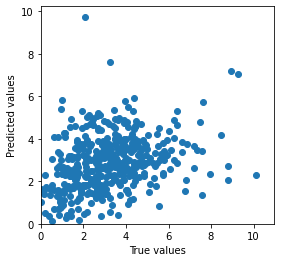

In [83]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])


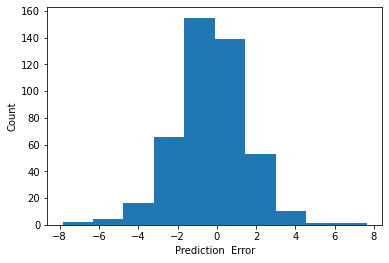

In [84]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction  Error")
_ = plt.ylabel("Count")

# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [85]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

#Extracting features required
test_sampled1 = test_sampled.dropna(axis=1)

uniquevalue1 = []

print(uniquevalue1)
type(uniquevalue1)

for i in test_sampled1.columns:
    if test_sampled1[i].nunique() == 1:
        del test_sampled1[i]

#del train_sampled1['Field_ID']
#test_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','3_S2_QA60','3_CLIM_def','3_CLIM_pdsi','4_S2_QA60','5_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','4_CLIM_pdsi', '5_CLIM_pdsi', '6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)
test_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)
test_sampled1.shape

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(test_sampled1)
test_sampled2 = pd.DataFrame(x_scaled)

# Get model predictions
preds = model.predict(test_sampled2)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

[]


,Field_ID,Yield
0,E9UZCEA,3.630695
1,1WGGS1Q,1.691266
2,EG2KXE2,3.466433
3,HC3GQXF,0.908727
4,7AK6GFK,6.488359


In [81]:
ss

,Field_ID,Yield
0,E9UZCEA,3.630695
1,1WGGS1Q,1.691266
2,EG2KXE2,3.466433
3,HC3GQXF,0.908727
4,7AK6GFK,6.488359
...,...,...
1050,3H89LWV,2.152397
1051,I6EYSGB,1.314062
1052,XOEIR44,2.823187
1053,YB307JG,1.126755


You can submit the Sub.csv file generated here on Zindi. This example scores ~2 (not as good as our score on our local test set, because the fields are more geographically separated). Now let's chat about ways to make this better:

# Improvements


1.   For the example above I chose the 'bands of interest' fairly randomly. A bit of research into which Sentinel 2 bands are used in this kind of task and what the different climate variables are should help make more informed choices there.
2.   We looked at all 12 months. Maize is normally planted just before the March-May rainy season (I think?) and harvested a few months later. Choose which months you'll prioritise to cut down on less useful data
3.   We looked at only the center pixel. Can you use a wider area to get better features? What about finding which pixels are most likely fields and sampling those?
4.   We did no model tuning, so obviously lots of fun to be had there
5.   Low-quality locations are often not fields - leave these out of your training set for better results. There are no low-quality (Quality=1) fields in the test set.
6.   Common measures such as NDVI, EVI etc can be computed by combining different bands. Look up how these vegetative indices are calculated for sentinel 2 and see if you can add those as features.
6.   ... As always, be creative - I'm sure there are lots more improvements to be made

